# Oxygen Budget Analysis 

This notebook analyzes the O$_2$ budget from POP output. Dissolved oxygen in the ocean's interior is simulated following:

$$
\frac{\partial{O_2}}{\partial{t}}= \underbrace{- \frac{\partial{U.O_2}}{\partial{x}} -\frac{\partial{V.O_2}}{\partial{y}}}_\text{Lateral Advection}
- \overbrace{\frac{\partial{W.O_2}}{\partial{z}}}^\text{Vertical Advection}
+ \underbrace{A_h.\nabla^2{O_2}}_\text{Lateral Mixing}
+\overbrace{\frac{\partial{}}{\partial{z}}k.\frac{\partial{O_2}}{\partial{z}}}^\text{Vertical Mixing}
+ \underbrace{ J(O_2)  }_\text{Sources - Sinks}
$$



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.simplefilter("ignore") # Silence warnings

import xarray as xr
import numpy as np
from tqdm import tqdm
import xgcm 
import pop_tools

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean
import cartopy
import cartopy.crs as ccrs
import proplot 
import matplotlib.patches as patches

from utils import *

In [13]:
C=CLSTR(1,15,200,10)

In [14]:
C

<Client: 'tcp://10.12.206.46:39657' processes=0 threads=0, memory=0 B>

In [15]:
def plot_depth_section(ax,x,z, var,cntf,lev,clr,units,title,coords,fs,fsx,lw,alp,cb_on,profile):
    if cntf==True: 
        cs= ax.contourf(x,z,var,levels=lev,cmap=clr,extend='both')
        if cb_on==True:
            cb = plt.colorbar(cs, ax=ax, orientation='vertical', extend='both',pad=0.02)#, aspect=20)  
#             cb.ax.set_title(units,fontsize=fs-1,pad=0.2)
            cb.set_label(units, rotation=0,size=fs-2,position=(0,1.08))
            cb.ax.tick_params(labelsize=fs-1)
            cb.ax.minorticks_off()
    if cntf==False: cs= ax.contour(x,z,var,colors=clr,linewidths=lw,levels=lev,alpha=alp)
    ax.set_title(title,loc='center',fontsize=fs)
    ax.set_ylim(coords[0]); ax.set_xlim(coords[1]); ax.minorticks_on(); 
    ax.set_ylabel('Depth (m)',fontsize=fs-2); 
    ax.set_aspect('auto')
    if profile=='lon': ax.set_xlabel('Latitude ($^{o}$N)',fontsize=fs-2)
    if profile=='lat': ax.set_xlabel('Longitude ($^{o}$E)',fontsize=fs-2)
    ax.set_title(title,pad=0.01,fontsize=fs, loc='center');
    ax.tick_params(axis='both', labelsize=fs)  
    return ax 

def plot_cmap(ax,lon,lat, var,vmn, vmx, stp, clr,units,title,coor,fs,fsx,lon_lab,lat_lab):
    ax.set_extent(coor,crs=cartopy.crs.PlateCarree())
    pc= ax.contourf(lon,lat,var,np.arange(vmn,vmx,stp),cmap=clr,transform=ccrs.PlateCarree(), extend='both') #, 
    land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',linewidth=0.1, edgecolor='black', facecolor='grey'))
    cb = plt.colorbar(pc, ax=ax, orientation='vertical', extend='both',pad=0.02)#, aspect=20)  
    cb.set_label(units, rotation=0,size=fs-3,position=(0.0,1.08))
#     cb.ax.set_title(units,fontsize=fs-1,pad=0.2)
    cb.ax.minorticks_off()
    cb.ax.tick_params(labelsize=fs)
    ax.set_aspect('auto')
    ax.set_title(title,loc='center',fontsize=fs)
    gl=ax.gridlines(draw_labels=True)
    gl.xlabel_style = {'size': fsx, 'color': 'black'}; gl.ylabel_style = {'size': fsx, 'color': 'black'}; 
    gl.xlabels_top = False; gl.ylabels_right= False; gl.xlines = False; gl.ylines = False
    gl.xlocator = mticker.FixedLocator(lon_lab); gl.ylocator = mticker.FixedLocator(lat_lab)
    gl.xformatter = LONGITUDE_FORMATTER ; gl.yformatter = LATITUDE_FORMATTER
    return ax


### Seasonal Cycle

In [5]:
dq=xr.open_mfdataset({'/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/TEND_Mon_Mean.nc',
                      '/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/DIV_Mon_Mean.nc',
                      '/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/VDIF_Mon_Mean.nc',
                      '/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/J_O2_Mon_Mean.nc',
                      '/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/UE_Mon_Mean.nc',
                      '/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/VN_Mon_Mean.nc',
                      '/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/WT_Mon_Mean.nc',
                       '/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/STF_O2_Mon_Mean.nc',
                        '/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/HDIF_Mon_Mean.nc',
                      '/glade/scratch/yeddebba/Mesoscale/HR/CLM/O2_Mon_Mean.nc',
                      '/glade/scratch/yeddebba/Mesoscale/HR/CLM/UVEL_Mon_Mean.nc',
                      '/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/O2_Budget_Eddy_Mon_Mean.nc',
#                         '/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/DIV_Mon_Mean.nc',
                      '/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/U_O2_Mon_Mean.nc',
                       '/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/V_O2_Mon_Mean.nc',
                       '/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/W_O2_Mon_Mean.nc',
#                       '/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/U_dO2_Mon_Mean.nc',
#                       '/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/V_dO2_Mon_Mean.nc',
#                       '/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/W_dO2_Mon_Mean.nc',
#                       '/glade/scratch/yeddebba/Mesoscale/HR/TPAC/final_budget/DIVd_Mon_Mean.nc',                      
                     })

dg = xr.open_dataset('/glade/scratch/yeddebba/Mesoscale/HR/TPAC/POP_GRID_F.nc')
dq=xr.merge([dq,dg],compat='override')
dq=volume(dq)

dq['DIVm']=dq.U_O2+dq.V_O2+dq.W_O2
dq

EKE=xr.open_mfdataset('/glade/scratch/yeddebba/Mesoscale/HR/TPAC/EKE.nc')
EKEm=EKE.groupby('time.month').mean(dim='time')

In [16]:
top=50; bot=150
Si=-5  ; Ni=5 
Ei=-100 ; Wi=-160

N,W=find_indices(dq.TLONG,dq.TLAT,360+Wi,Ni)
S,E=find_indices(dq.TLONG,dq.TLAT,360+Ei,Si)

In [18]:
O2m=(dq.O2*mmol_mol*dq.VOL*cm3_m3).isel(nlon=slice(W,E)).sum('nlon').isel(nlat=slice(S,N)).sum('nlat').sel(z_t=slice(top*1e2,bot*1e2)).sum(dim='z_t').compute()

In [21]:
EK=EKEm.__xarray_dataarray_variable__.isel(nlon=slice(W,E)).mean('nlon').isel(nlat=slice(S,N)).mean('nlat').compute()

In [17]:
dshb=(dq.isel(nlon=slice(W,E)).sum('nlon').isel(nlat=slice(S,N)).sum('nlat').sel(z_t=slice(top*1e2,bot*1e2)).sum(dim='z_t')).compute()
VOL_hr=(dq.VOL.isel(nlon=slice(W,E)).sum('nlon').isel(nlat=slice(S,N)).sum('nlat').sel(z_t=slice(top*1e2,bot*1e2)).sum(dim='z_t')*cm3_m3).compute()
dshb

<xarray.Dataset>
Dimensions:      (month: 12, z_w: 41, z_w_top: 41)
Coordinates:
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * z_w          (z_w) float32 0.0 1e+03 2e+03 ... 8.296e+04 9.28e+04 1.041e+05
  * z_w_top      (z_w_top) float32 0.0 1e+03 2e+03 ... 9.28e+04 1.041e+05
Data variables: (12/33)
    DIV          (month) float64 -1.264e+15 -1.488e+15 ... -2.093e+15 -2.051e+15
    Up_O2p       (month) float64 -3.329e+13 -3.381e+13 ... -3.732e+13 -4.187e+13
    Vp_O2p       (month) float64 2.338e+14 1.092e+14 ... 2.452e+14 1.246e+14
    Wp_O2p       (month) float64 3.421e+14 2.811e+14 ... 3.572e+14 3.557e+13
    DIVp         (month) float64 5.432e+14 3.564e+14 ... 5.657e+14 1.186e+14
    HDIF         (month) float64 2.849e+10 2.951e+10 ... 5.473e+10 4.454e+10
    ...           ...
    TAREA        float64 7.484e+16
    UAREA        float64 7.484e+16
    dz           float32 1e+04
    dzw          (z_w) float32 500.0 1e+03 1e+03 ... 1.059e+04 1.215e+04
    VOL          float64 7.483e+20
    DIVm         (month) float64 -1.807e+15 -1.845e+15 ... -2.659e+15 -2.17e+15

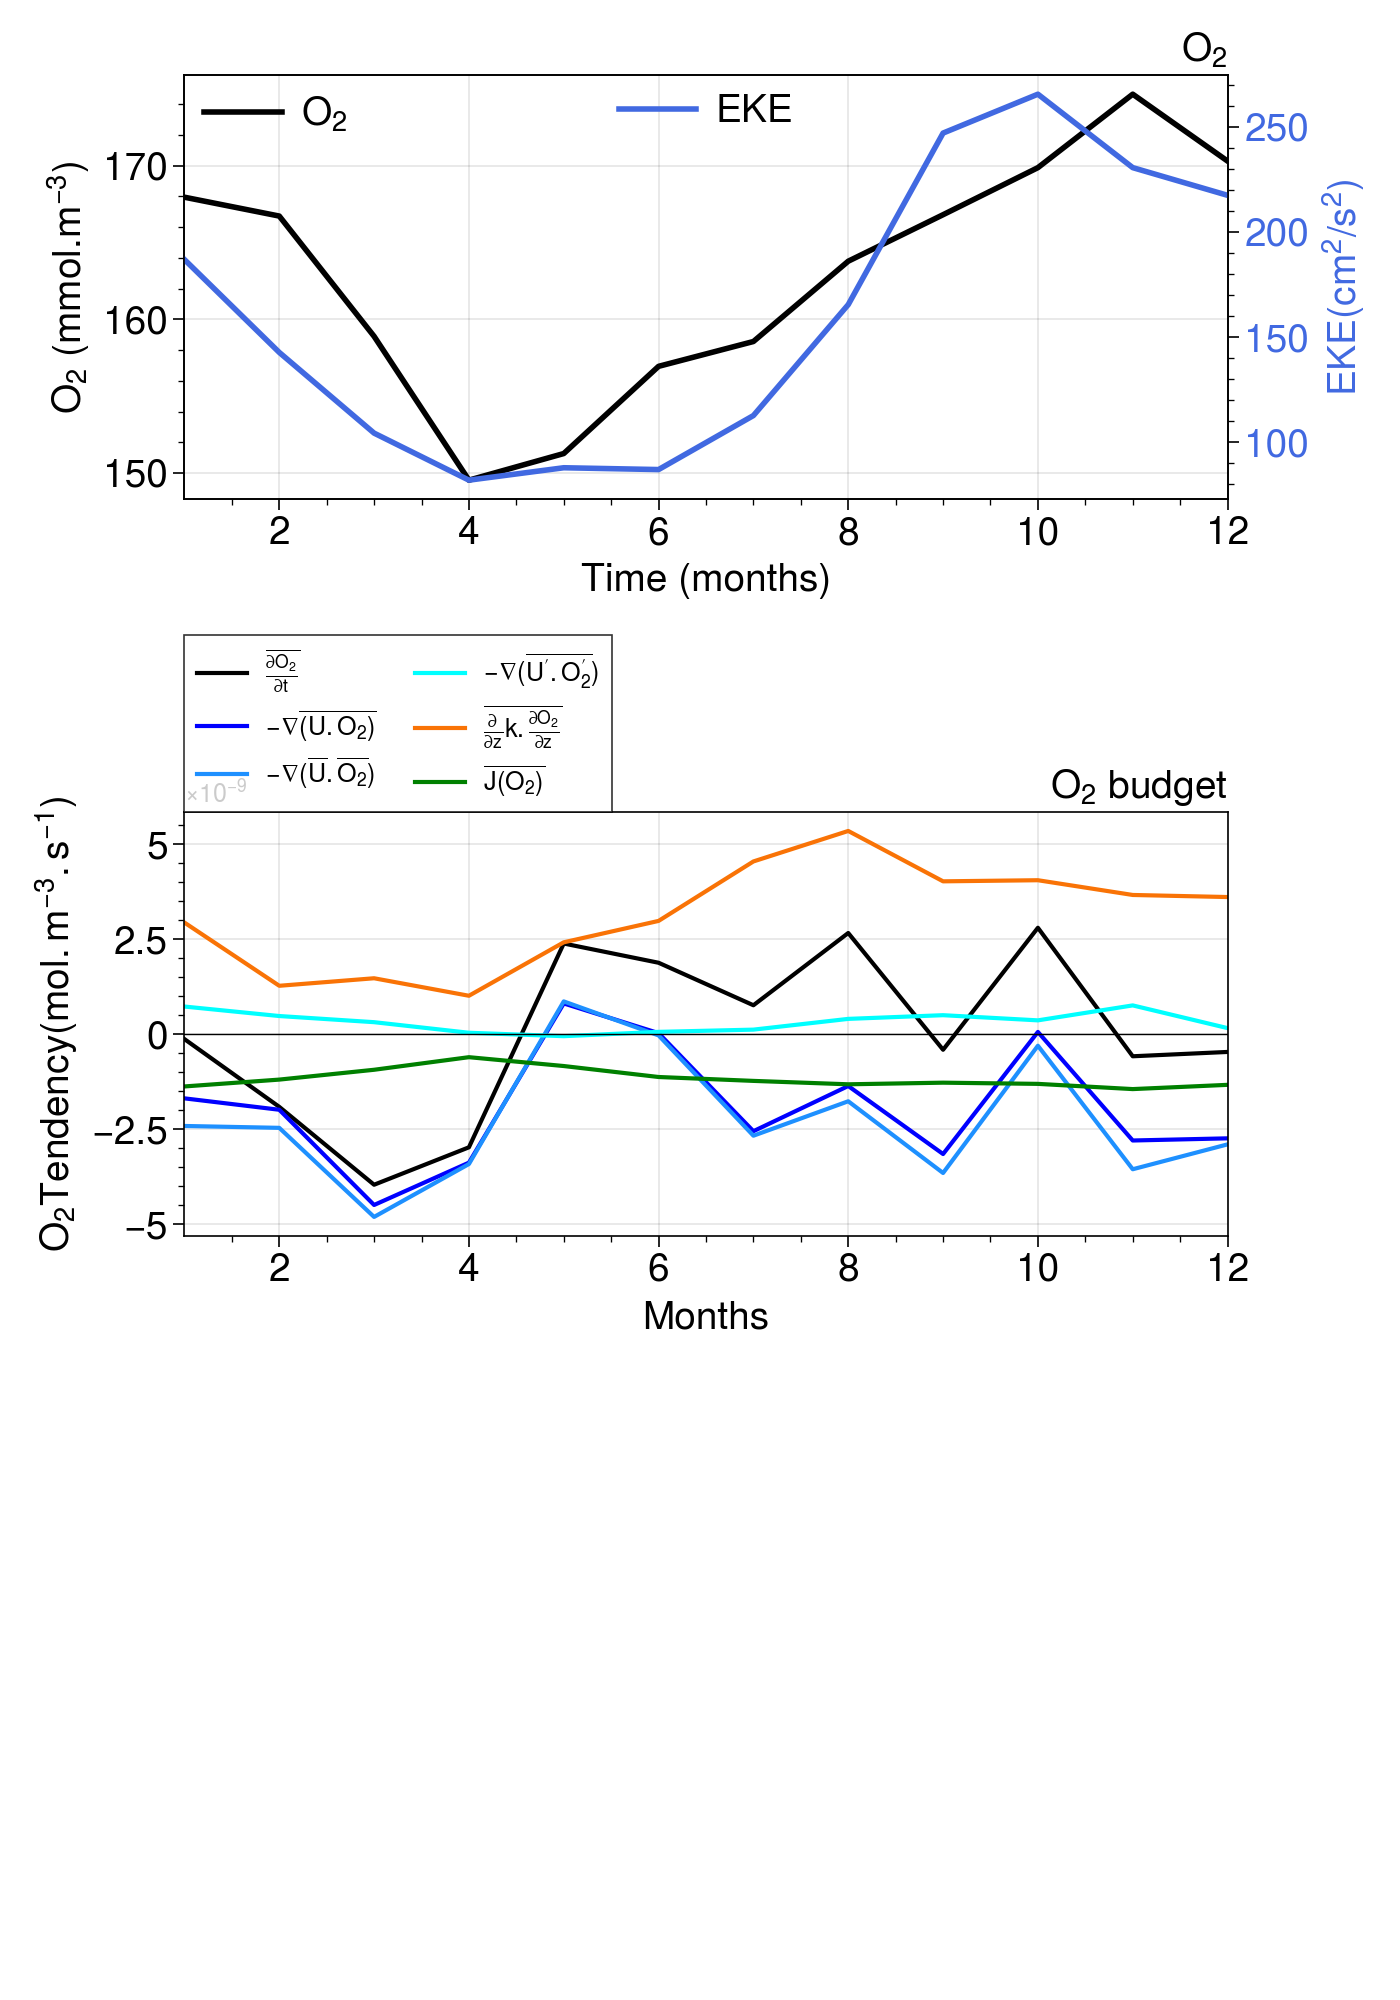

In [22]:
fig = plt.figure(figsize=(7,10),dpi=100, facecolor='white')
# fig = plt.subplots(3,1, figsize=(7,10))
fs=14
gs2 = fig.add_gridspec(nrows=3, ncols=1)#, top=0.3, left=0.38, right=0.95, wspace=0.4, hspace=0.2)    

ax = fig.add_subplot(gs2[0,0])
pc=ax.plot(dq.month,O2m/mmol_mol/VOL_hr,color='black', Linewidth=2,label='O$_2$')
ax.set_xlim([0., 13.])
# ax.set_ylim([np.min(O2_int)*0.95, np.max(O2_int)*1.05])
ax.minorticks_on()
ax.set_xlabel('Time (months)',fontsize=fs)
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('O$_2$ (mmol.m$^{-3}$)',fontsize=fs)
ax.set_title('O$_2$',fontsize=fs,loc='right')
ax.tick_params(axis='both', which='major', labelsize=fs)
plt.legend(loc='upper left',fontsize=fs,frameon=False)


ax2 = ax.twinx()
color = 'royalblue'
ax2.set_ylabel('EKE(cm$^2$/s$^2$)', color=color,fontsize=fs)  
ax2.plot(dq.month,EK,color=color,Linewidth=2,label='EKE') 
ax2.tick_params(axis='y', labelcolor=color)
ax2.tick_params(axis='both', which='major', labelsize=fs)
ax2.grid(False)
plt.xlim(1,12)
plt.legend(loc='upper center',fontsize=fs,frameon=False)


VARS=[dshb.TEND_O2,
      dshb.DIV,
      dshb.DIVm,
      dshb.DIVp,
      dshb.VDIF,
      dshb.J_O2,]

title=[r' $\overline{\frac{\partial{O_2}}{\partial{t}}}$ ', 
     r' $-\nabla{\overline{(U.O_2)}}$ ',
     r' $-\nabla{(\overline{U}.\overline{O_2})}$ ',
     r" $-\nabla{(\overline{U'.O_2'})}$",
#      r' $\overline{A_h.\nabla_H^2{({O_2})}}$',
     r' $\overline{\frac{\partial{}}{\partial{z}}k.\frac{\partial{O_2}}{\partial{z}}}$ ',
     r' $\overline{J(O_2)}$ ',]

clr=['black','blue','dodgerblue','cyan','orange','green']#

ax = fig.add_subplot(gs2[1,0])

i=0
for VAR in VARS:
    ax.plot(dq.month,VAR * nmol_mol/VOL_hr,
               label=str(title[i]), color=clr[i],lw=1.5)
    i+=1

ax.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=2)
ax.set_title('O$_2$ budget',size=14,loc='right')# integrated over '+str(abs(Wi))+'W-'+str(abs(Ei))+'W '+str(top)+'-'+str(bot)+'m')
ax.set_ylabel(r'O$_2 Tendency (mol.m^{-3}.s^{-1})$',fontsize=14)
ax.set_xlabel('Months',fontsize=14)
ax.axhline(y=0.0, color='k',lw=0.5)
ax.minorticks_on()
ax.xaxis.set_ticks_position('bottom')
# ax.set_title('b) ',fontsize=fs+1,loc='left')
ax.tick_params(axis='both', which='major', labelsize=fs)
# plt.legend(loc='upper left',fontsize=fs,frameon=False)
plt.xlim(1,12)

plt.tight_layout()

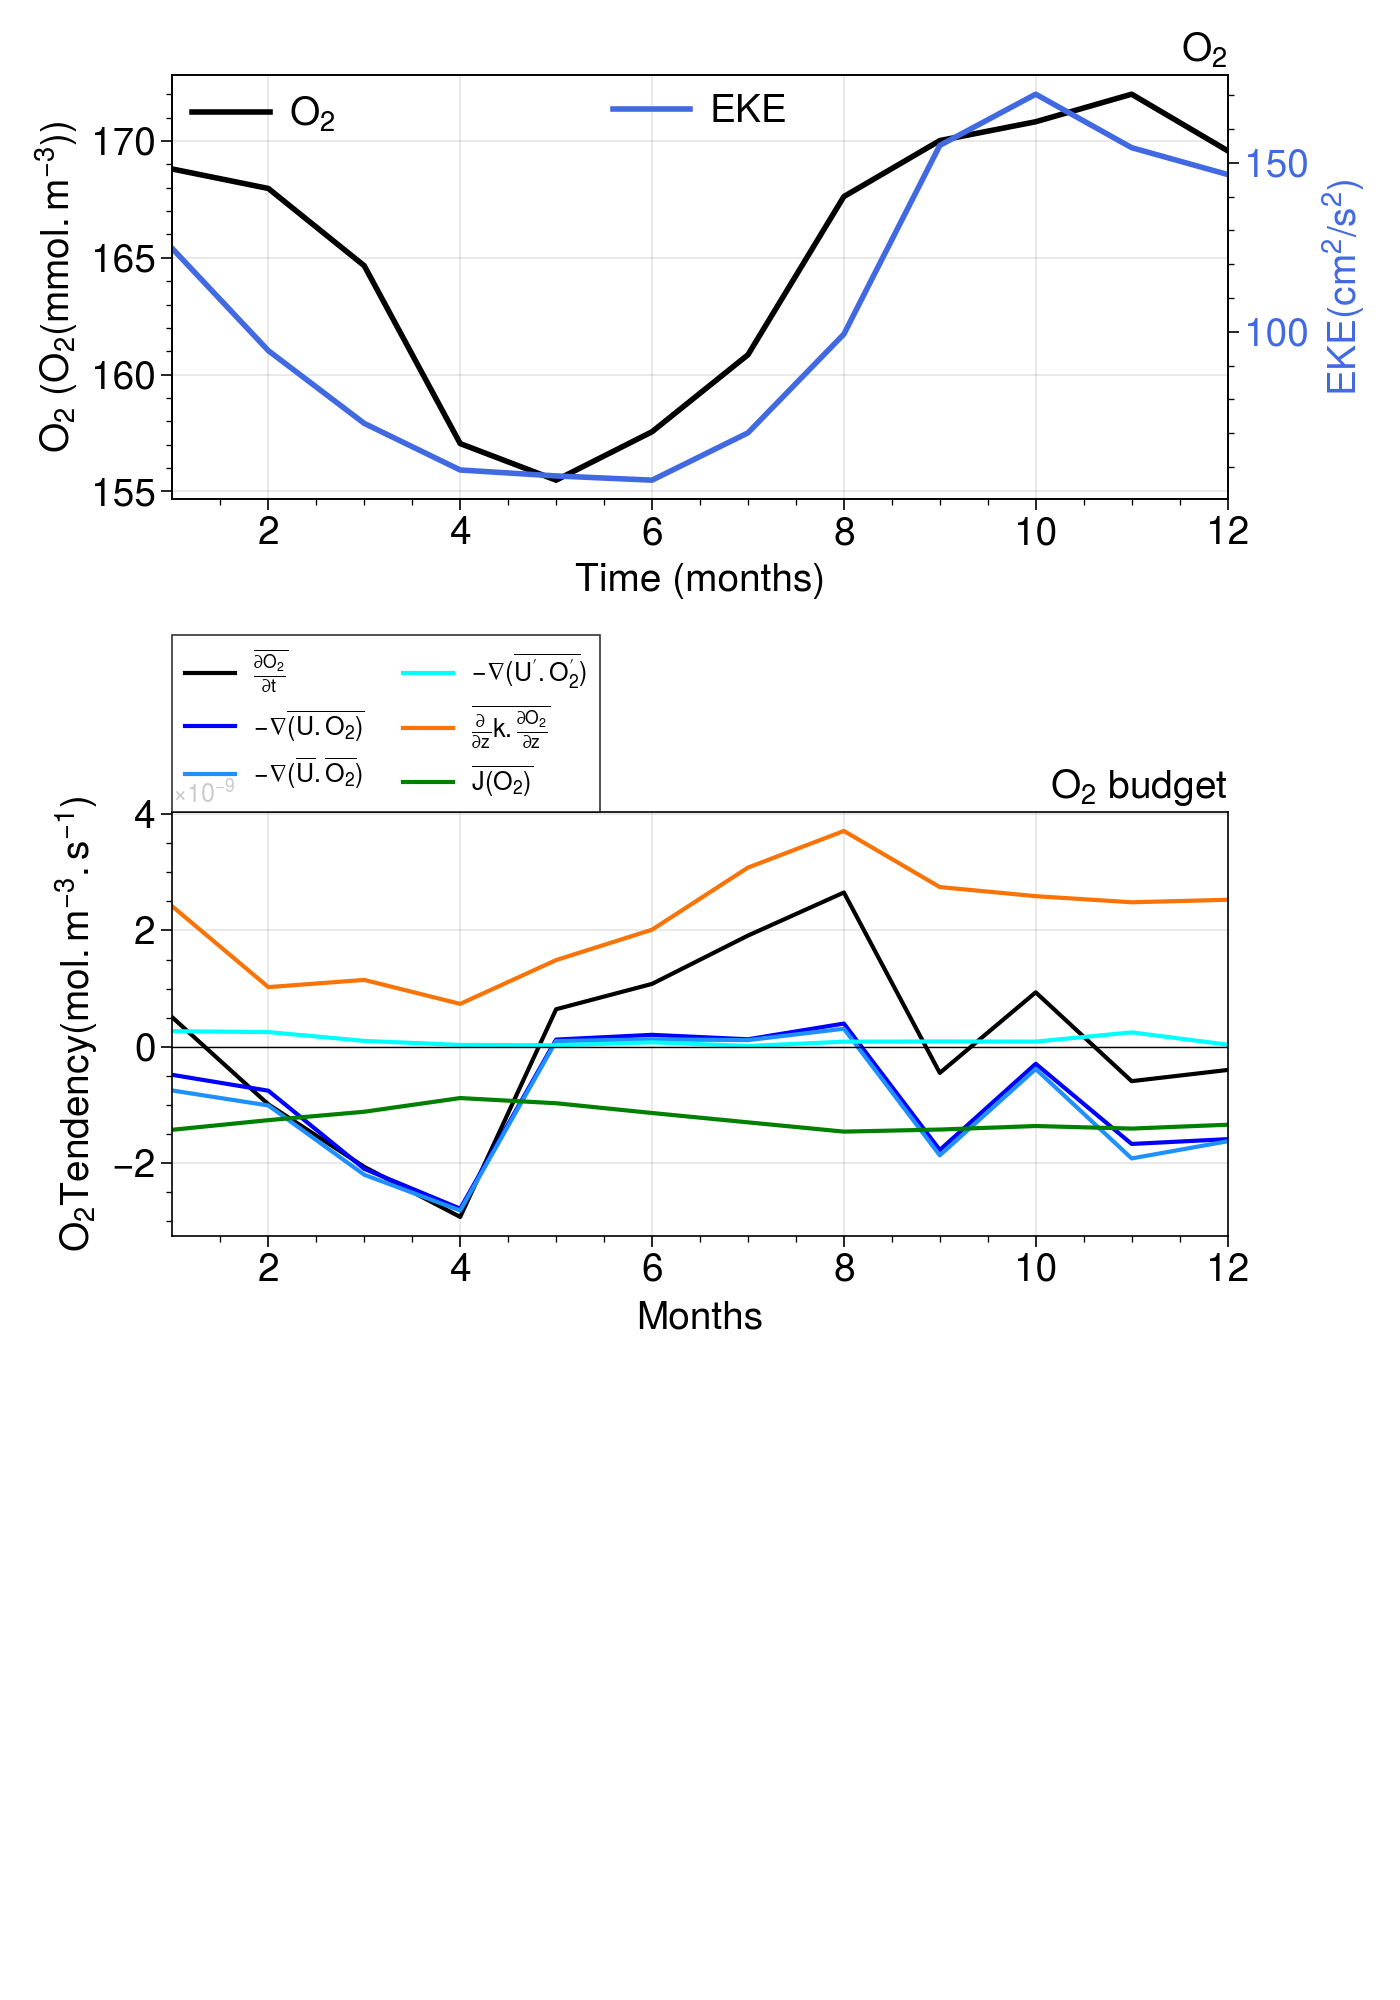

In [263]:
fig = plt.figure(figsize=(7,10),dpi=100, facecolor='white')
# fig = plt.subplots(3,1, figsize=(7,10))
fs=14
gs2 = fig.add_gridspec(nrows=3, ncols=1)#, top=0.3, left=0.38, right=0.95, wspace=0.4, hspace=0.2)    

ax = fig.add_subplot(gs2[0,0])
pc=ax.plot(dq.month,O2m/mmol_mol/VOL_hr,color='black', Linewidth=2,label='O$_2$')
ax.set_xlim([0., 13.])
# ax.set_ylim([np.min(O2_int)*0.95, np.max(O2_int)*1.05])
ax.minorticks_on()
ax.set_xlabel('Time (months)',fontsize=fs)
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('O$_2$ ($O_2 (mmol.m^{-3})$)',fontsize=fs)
ax.set_title('O$_2$',fontsize=fs,loc='right')
ax.tick_params(axis='both', which='major', labelsize=fs)
plt.legend(loc='upper left',fontsize=fs,frameon=False)


ax2 = ax.twinx()
color = 'royalblue'
ax2.set_ylabel('EKE(cm$^2$/s$^2$)', color=color,fontsize=fs)  
ax2.plot(dq.month,EK,color=color,Linewidth=2,label='EKE') 
ax2.tick_params(axis='y', labelcolor=color)
ax2.tick_params(axis='both', which='major', labelsize=fs)
ax2.grid(False)
plt.xlim(1,12)
plt.legend(loc='upper center',fontsize=fs,frameon=False)


VARS=[dshb.TEND_O2,
      dshb.DIV,
      dshb.DIVm,
      dshb.DIVp,
      dshb.VDIF,
      dshb.J_O2,]

title=[r' $\overline{\frac{\partial{O_2}}{\partial{t}}}$ ', 
     r' $-\nabla{\overline{(U.O_2)}}$ ',
     r' $-\nabla{(\overline{U}.\overline{O_2})}$ ',
     r" $-\nabla{(\overline{U'.O_2'})}$",
#      r' $\overline{A_h.\nabla_H^2{({O_2})}}$',
     r' $\overline{\frac{\partial{}}{\partial{z}}k.\frac{\partial{O_2}}{\partial{z}}}$ ',
     r' $\overline{J(O_2)}$ ',]

clr=['black','blue','dodgerblue','cyan','orange','green']#

ax = fig.add_subplot(gs2[1,0])

i=0
for VAR in VARS:
    ax.plot(dq.month,VAR * nmol_mol/VOL_hr,
               label=str(title[i]), color=clr[i],lw=1.5)
    i+=1

ax.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=2)
ax.set_title('O$_2$ budget',size=14,loc='right')# integrated over '+str(abs(Wi))+'W-'+str(abs(Ei))+'W '+str(top)+'-'+str(bot)+'m')
ax.set_ylabel(r'O$_2 Tendency (mol.m^{-3}.s^{-1})$',fontsize=14)
ax.set_xlabel('Months',fontsize=14)
ax.axhline(y=0.0, color='k',lw=0.5)
ax.minorticks_on()
ax.xaxis.set_ticks_position('bottom')
# ax.set_title('b) ',fontsize=fs+1,loc='left')
ax.tick_params(axis='both', which='major', labelsize=fs)
# plt.legend(loc='upper left',fontsize=fs,frameon=False)
plt.xlim(1,12)

plt.tight_layout()

100%|██████████| 4/4 [16:42<00:00, 250.74s/it]


<bound method Figure.tight_layout of <Figure size 2500x2500 with 48 Axes>>

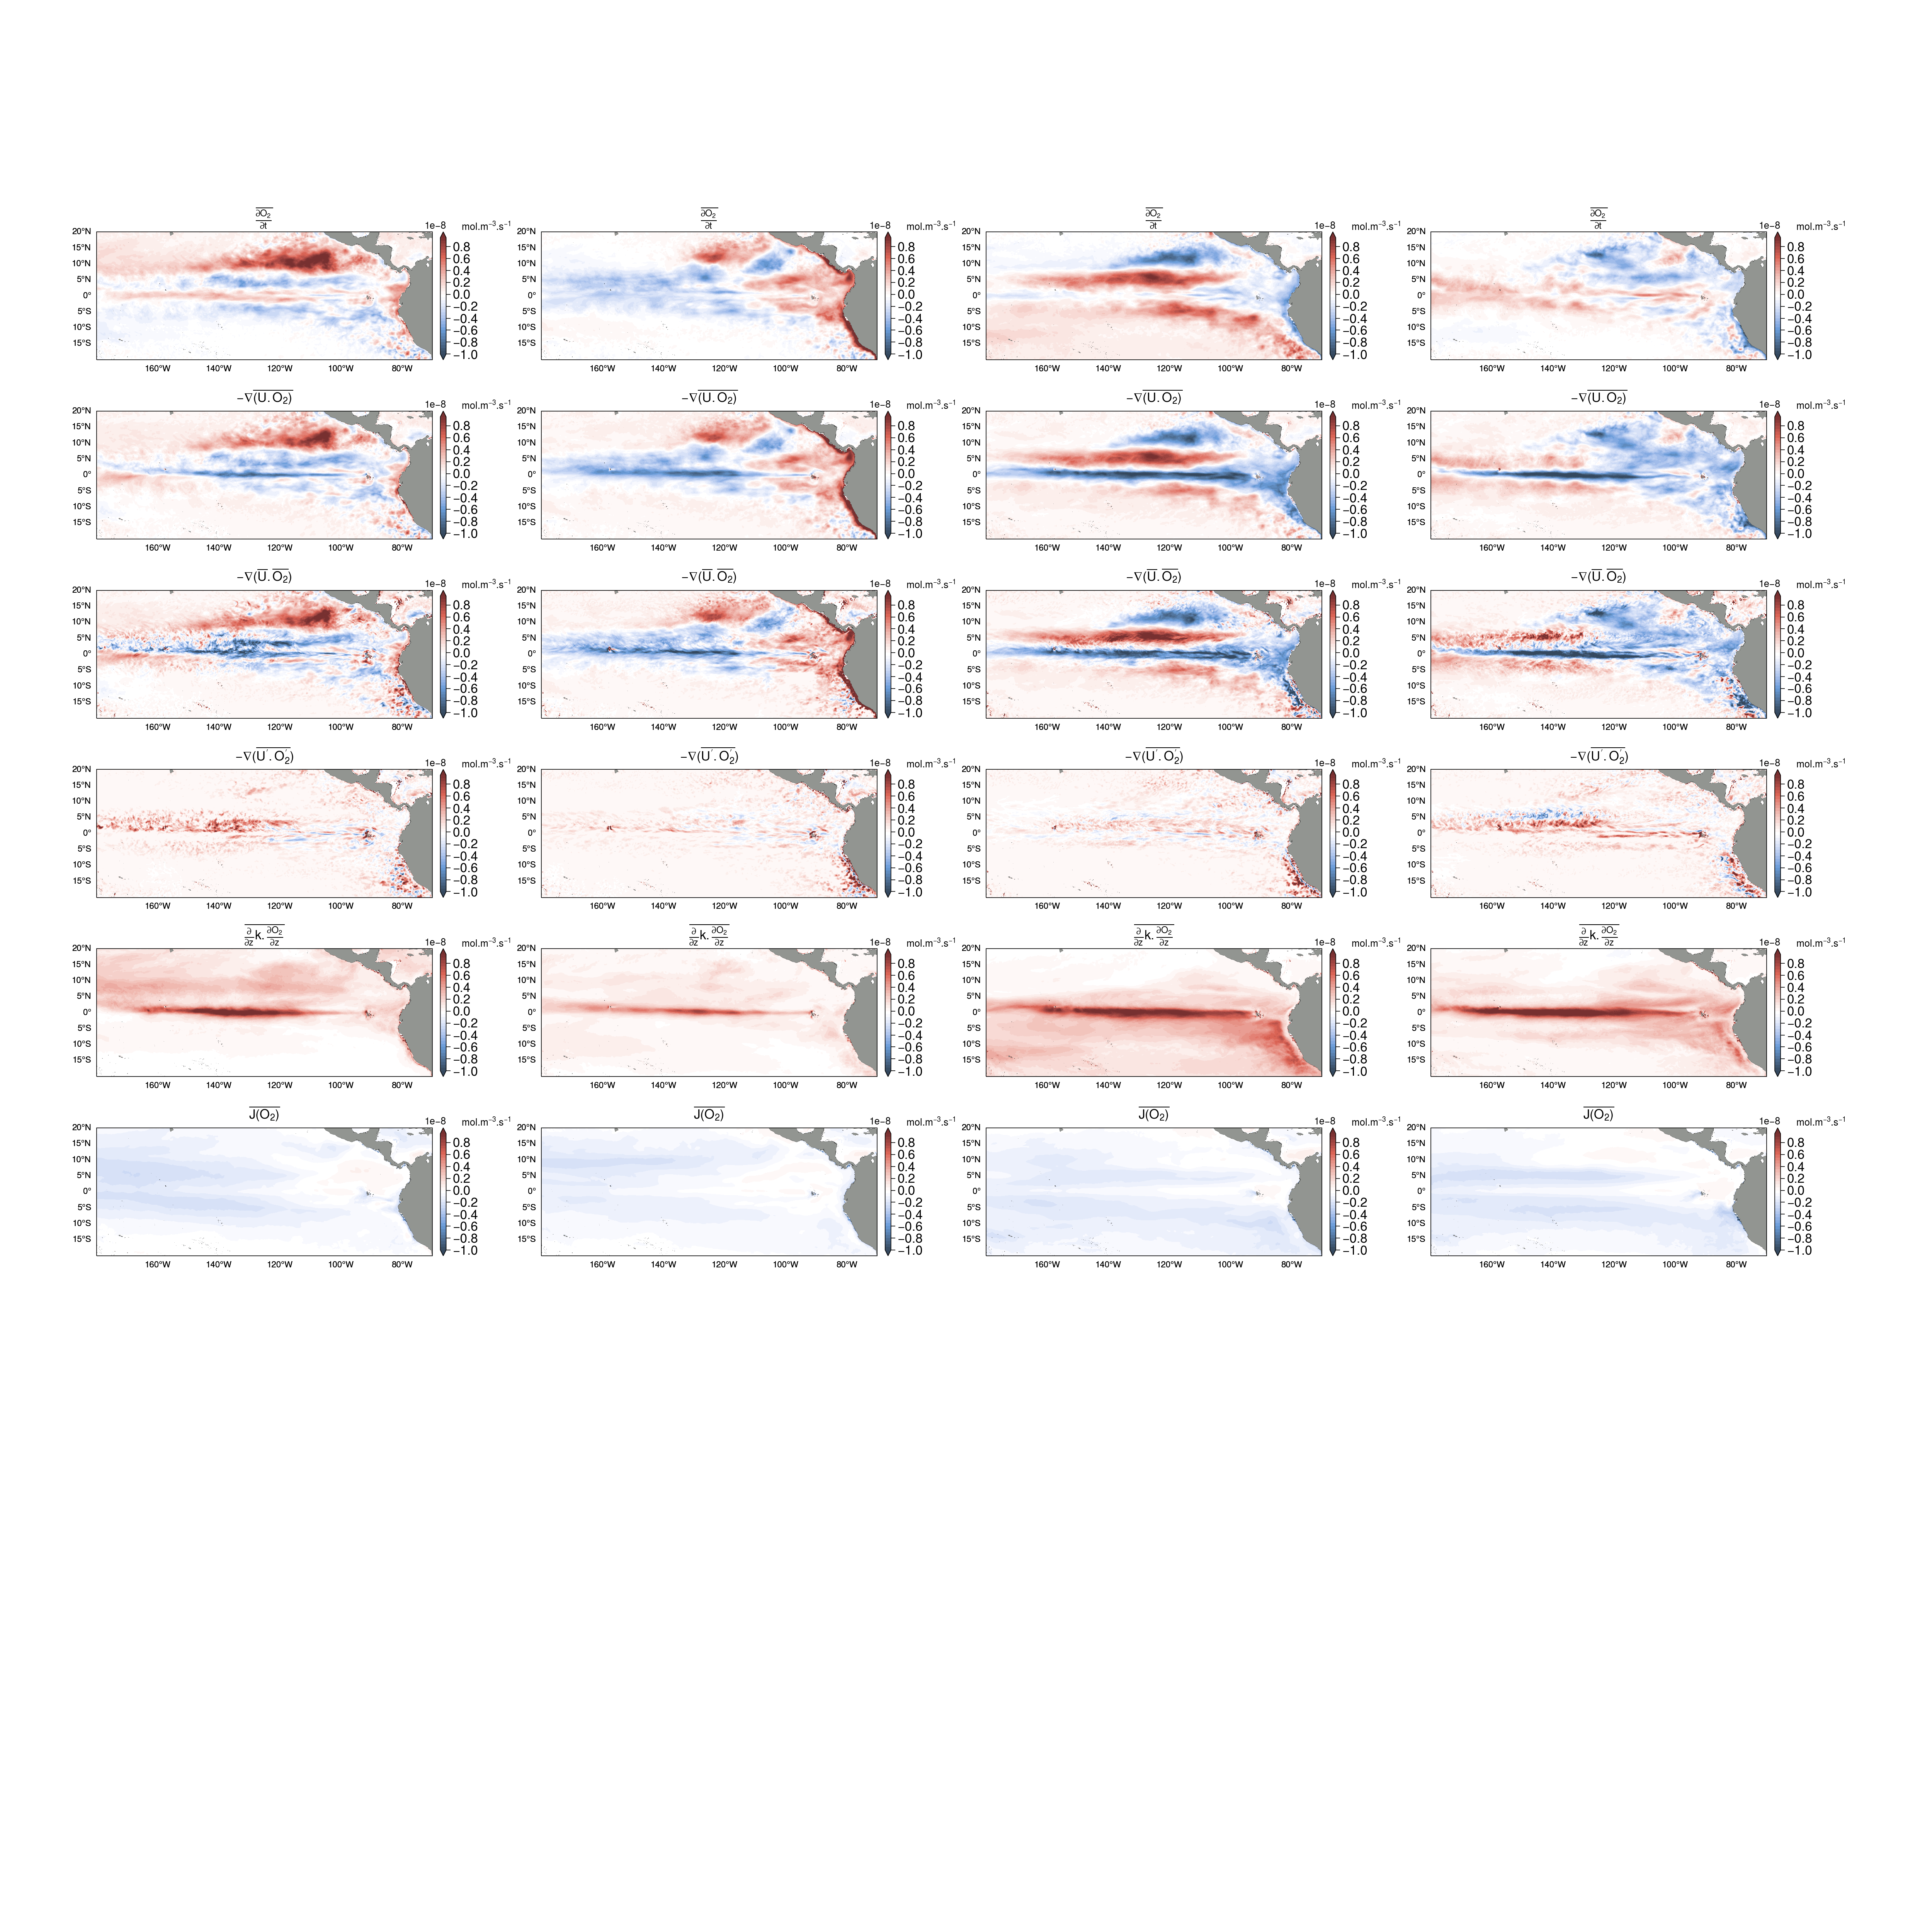

In [169]:
fig = plt.figure(figsize=(25,25),dpi=100)
fs=12; fsx=8
EE=-200.0; WW=-70.1; SS=-20.0; NN=20.1
coor=[EE,WW,SS,NN]; CL=215.0 # central longtiude 
lon_lab=np.concatenate([np.arange(EE,WW,20)])
lat_lab=np.arange(SS,NN,5)

clr_o2='NegPos'
om_clr='blue'
omz_clr='green'
odz_clr='lime'

VAR= [dq.TEND_O2.sel(z_t=slice(top*1e2,bot*1e2)).sum('z_t')*nmol_mol/(dsh.VOL.sel(z_t=slice(top*1e2,bot*1e2)).sum('z_t')*cm3_m3),
      dq.DIV.sel(z_t=slice(top*1e2,bot*1e2)).sum('z_t')*nmol_mol/(dsh.VOL.sel(z_t=slice(top*1e2,bot*1e2)).sum('z_t')*cm3_m3),
      dq.DIVm.sel(z_t=slice(top*1e2,bot*1e2)).sum('z_t')*nmol_mol/(dsh.VOL.sel(z_t=slice(top*1e2,bot*1e2)).sum('z_t')*cm3_m3),
      dq.DIVp.sel(z_t=slice(top*1e2,bot*1e2)).sum('z_t')*nmol_mol/(dsh.VOL.sel(z_t=slice(top*1e2,bot*1e2)).sum('z_t')*cm3_m3),
      dq.VDIF.sel(z_t=slice(top*1e2,bot*1e2)).sum('z_t')*nmol_mol/(dsh.VOL.sel(z_t=slice(top*1e2,bot*1e2)).sum('z_t')*cm3_m3),
      dq.J_O2.sel(z_t=slice(top*1e2,bot*1e2)).sum('z_t')*nmol_mol/(dsh.VOL.sel(z_t=slice(top*1e2,bot*1e2)).sum('z_t')*cm3_m3),]

units=['   mol.m$^{-3}$.s$^{-1}$']
title=[r'$\overline{\frac{\partial{O_2}}{\partial{t}}}$ ', 
     r'$-\nabla{\overline{(U.O_2)}}$ ',
     r'$-\nabla{(\overline{U}.\overline{O_2})}$ ',
     r"$-\nabla{(\overline{U'.O_2'})}$",
#      r'$-\nabla_H{\overline{(U.O_2)}}$ ',
#      r'$\overline{\frac{\partial{w.O_2}}{\partial{z}}}$ ',
     r'$\overline{\frac{\partial{}}{\partial{z}}k.\frac{\partial{O_2}}{\partial{z}}}$ ',
     r'$\overline{J(O_2)}$ ']



clrs=[clr_o2]
lmax=10e-9
lmin=-lmax
lstp=lmax*0.5e-1


gs = fig.add_gridspec(nrows=6, ncols=4, bottom=0.35,left=0.05, right=0.95, wspace=0.1, hspace=0.4)
rng=[0,1,2,3,4,5]
r=[0,1,2,3,4,5]
c=[0,1,2,3]
rr=[[0,1,11],
    [2,3,4],
    [5,6,7],
    [8,9,10]]

for j in tqdm(np.arange(0,4)):#len(VAR))):
    for i in tqdm(np.arange(0,6)):#len(VAR))):
        ax = fig.add_subplot(gs[r[i], c[j]] ,projection=ccrs.PlateCarree())
        ax = plot_cmap(ax,dsh.TLONG,dsh.TLAT, VAR[i].isel(month=rr[j]).mean('month'),lmin, lmax, lstp,
                       clrs[0],units[0],title[i],coor,fs,fsx, lon_lab,lat_lab)
    #     (dv.UVEL).isel(z_t=15).plot.contour(colors='black',linewidths=0.7,levels=np.arange(-150,150,50))
#         ax.contour(dsh.TLONG,dsh.TLAT, dsh.O2.isel(z_t=15),colors=omz_clr,linewidths=0.9,levels=np.arange(60,60.1,5))    
#         ax.contour(dsh.TLONG,dsh.TLAT, dsh.O2.isel(z_t=15),colors=odz_clr,linewidths=0.9,levels=np.arange(20,20.1,5)) 
#         if i==0: 
#             ax.contour(dsh.TLONG,dsh.TLAT, dsh.O2.isel(z_t=15),colors='black',linewidths=0.3,levels=np.arange(0,200.1,10)) 
        gl=ax.gridlines(draw_labels=True)
        gl.xlabel_style = {'size': fsx, 'color': 'black'}; gl.ylabel_style = {'size': fsx, 'color': 'black'}; 
        gl.xlabels_top = False; gl.ylabels_right= False; gl.xlines = False; gl.ylines = False
        gl.xlocator = mticker.FixedLocator(lon_lab); gl.ylocator = mticker.FixedLocator(lat_lab)
        gl.xformatter = LONGITUDE_FORMATTER ; gl.yformatter = LATITUDE_FORMATTER
fig.tight_layout

100%|██████████| 4/4 [03:24<00:00, 51.14s/it]


<bound method Figure.tight_layout of <Figure size 2500x2500 with 48 Axes>>

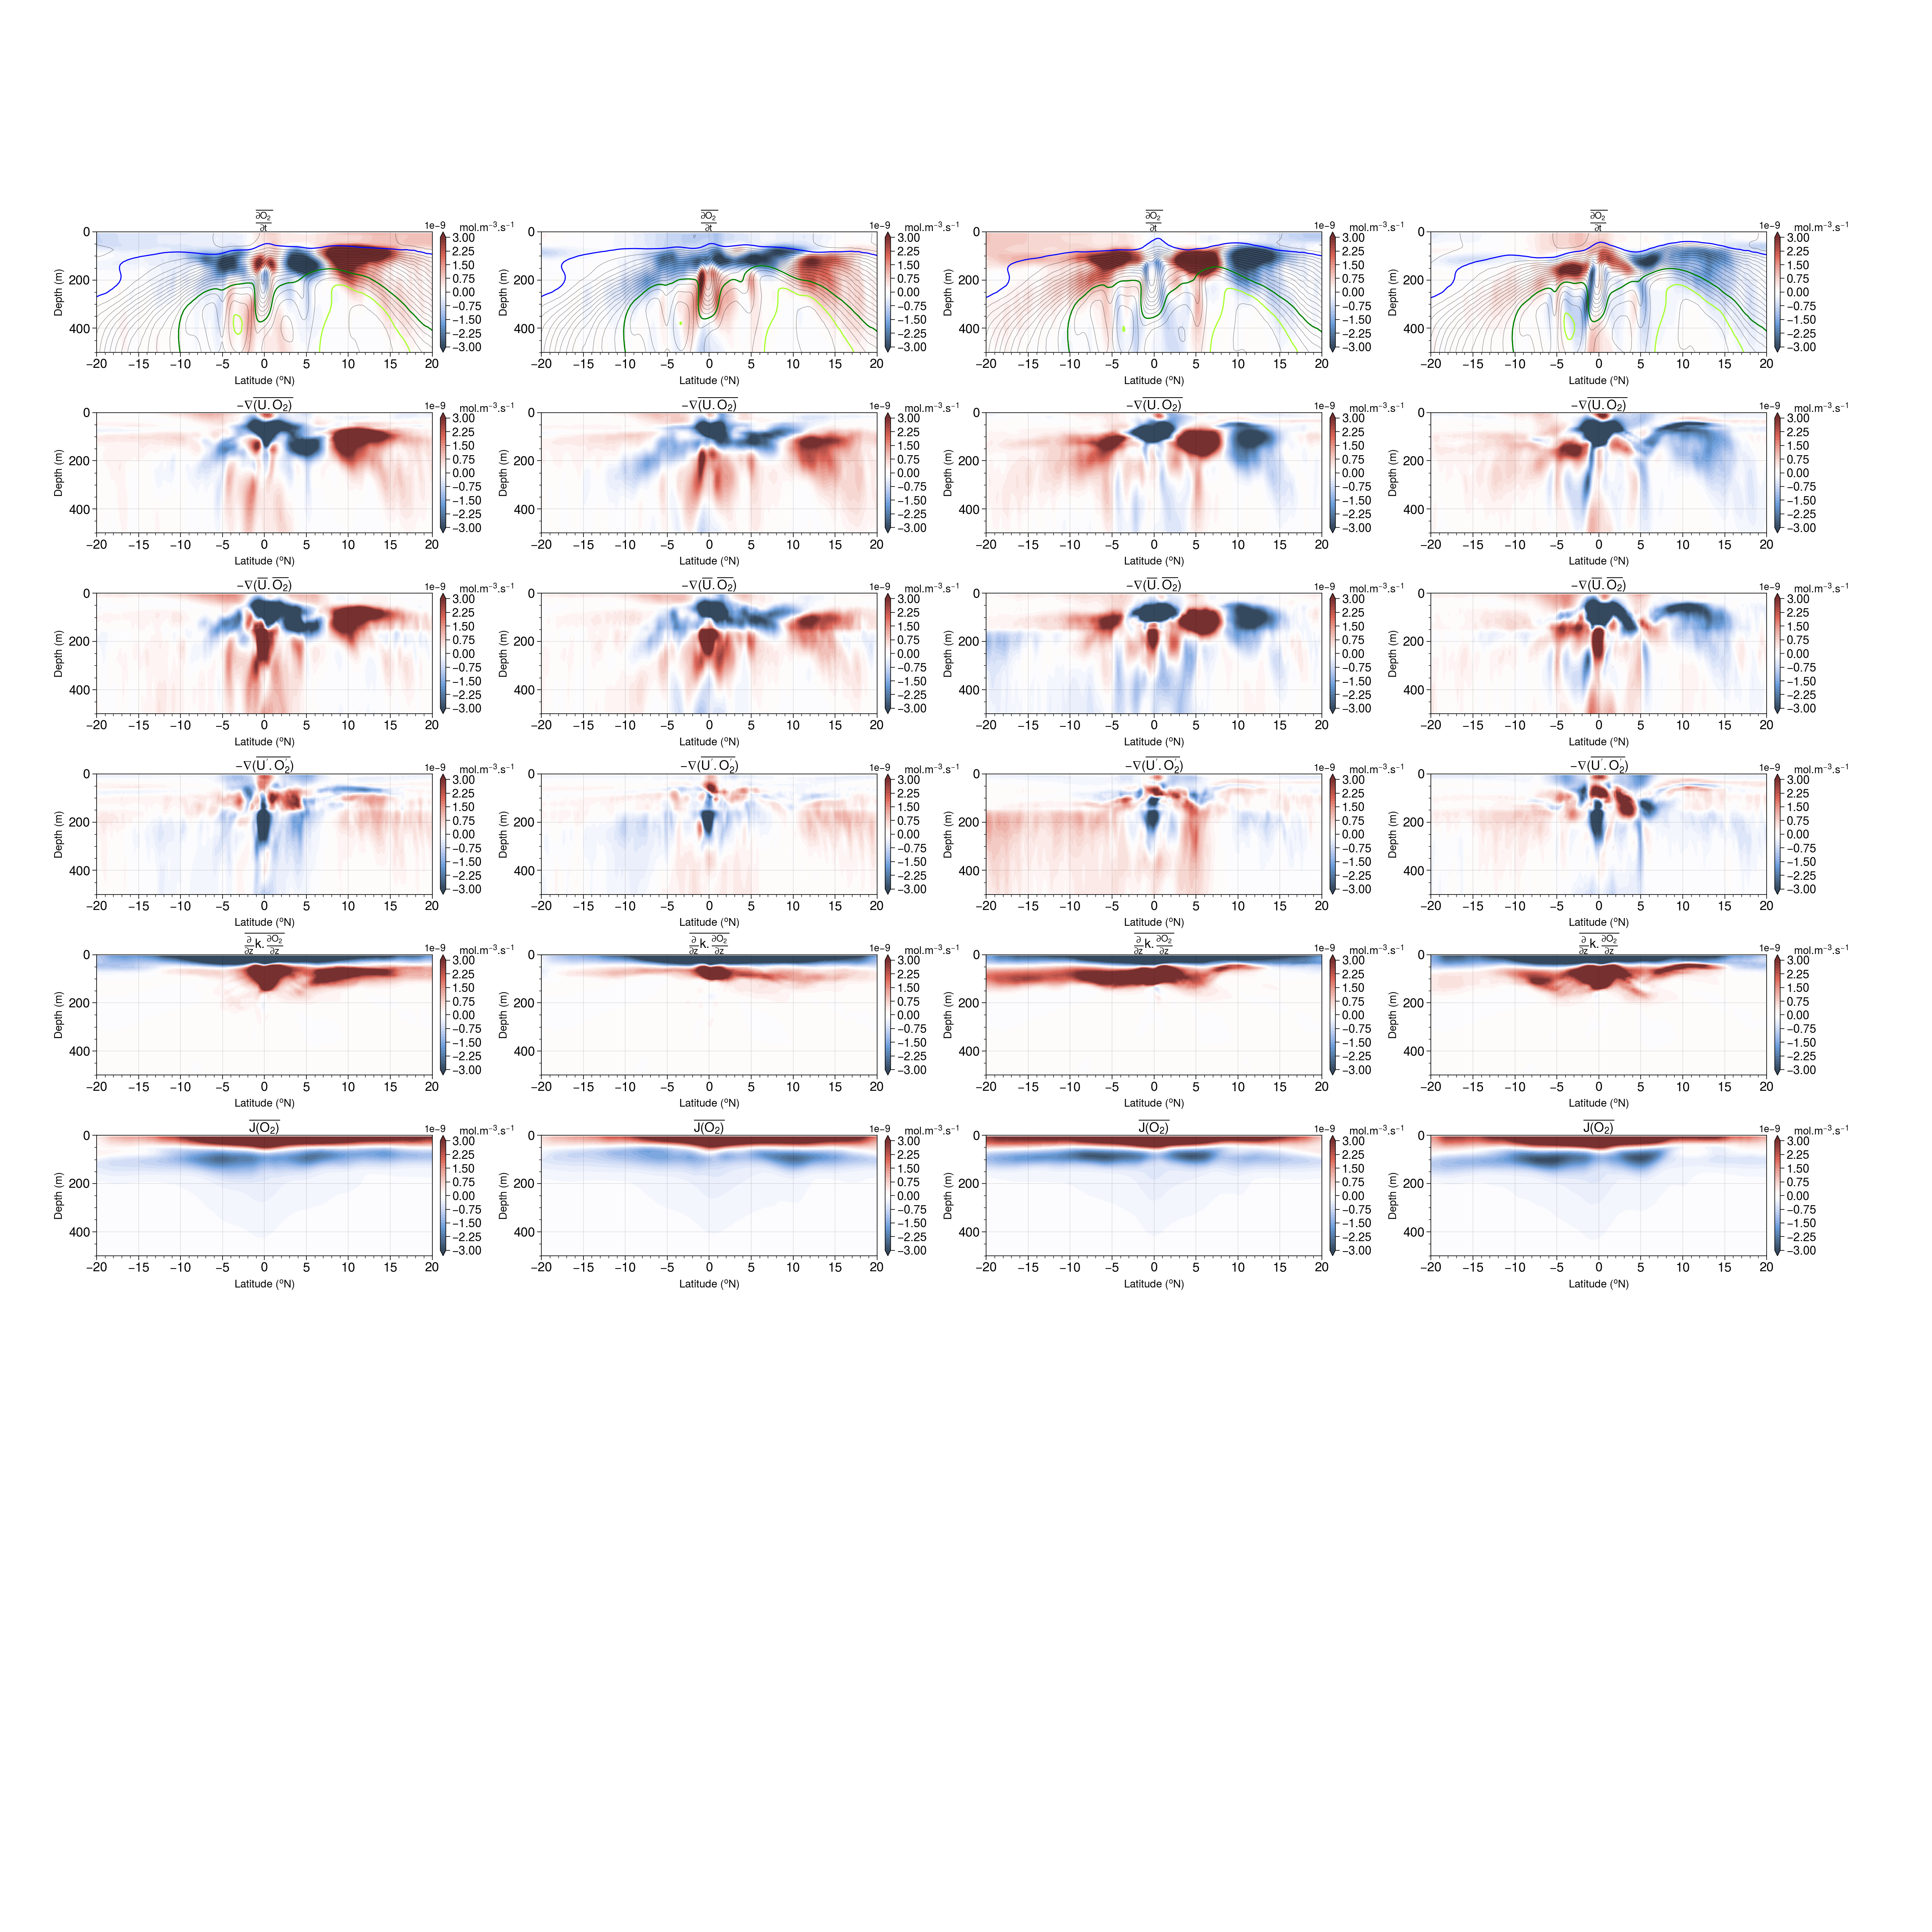

In [151]:
fig = plt.figure(figsize=(25,25),dpi=100)

fs=12; fsx=5; 
SS=-20; NN=20
tops=0. ; bots=500.; 
coords=[[bots,tops],[SS,NN]]

clr_o2='NegPos'
om_clr='blue'
omz_clr='green'
odz_clr='lime'
var= [dsh.TEND_O2.isel(nlon=slice(W,E)).sum('nlon')*nmol_mol/(dsh.VOL.isel(nlon=slice(W,E)).sum('nlon')*cm3_m3),
      dsh.DIV.isel(nlon=slice(W,E)).sum('nlon')*nmol_mol/(dsh.VOL.isel(nlon=slice(W,E)).sum('nlon')*cm3_m3),
      dsh.DIVm.isel(nlon=slice(W,E)).sum('nlon')*nmol_mol/(dsh.VOL.isel(nlon=slice(W,E)).sum('nlon')*cm3_m3),
      dsh.DIVp.isel(nlon=slice(W,E)).sum('nlon')*nmol_mol/(dsh.VOL.isel(nlon=slice(W,E)).sum('nlon')*cm3_m3),
      dsh.VDIF.isel(nlon=slice(W,E)).sum('nlon')*nmol_mol/(dsh.VOL.isel(nlon=slice(W,E)).sum('nlon')*cm3_m3),
      dsh.J_O2.isel(nlon=slice(W,E)).sum('nlon')*nmol_mol/(dsh.VOL.isel(nlon=slice(W,E)).sum('nlon')*cm3_m3),]
cntf= True ; cnt= False 
units=['mol.m$^{-3}$.s$^{-1}$']
title=[r'$\overline{\frac{\partial{O_2}}{\partial{t}}}$ ', 
     r'$-\nabla{\overline{(U.O_2)}}$ ',
     r'$-\nabla{(\overline{U}.\overline{O_2})}$ ',
     r"$-\nabla{(\overline{U'.O_2'})}$",
     r'$\overline{\frac{\partial{}}{\partial{z}}k.\frac{\partial{O_2}}{\partial{z}}}$ ',
     r'$\overline{J(O_2)}$ ',
     r'$\overline{u}$ ', ]
clr=[clr_o2]
lw=0.5; alp=1;cb_on=True

lo = -3e-9; hi = -lo; hi2 = -lo; dsc = -lo*0.5e-1
y=dsh.TLAT[:,E]
z= dsh.z_t*1e-2

gs = fig.add_gridspec(nrows=6, ncols=4, bottom=0.35,left=0.05, right=0.95, wspace=0.1, hspace=0.5)
rng=[0,1,2,3,4,5]
r=[0,1,2,3,4,5]
c=[0,1,2,3]
rr=[[0,1,11],
    [2,3,4],
    [5,6,7],
    [8,9,10]]
    

j=[0,0,0,0,0,0,0]; i=[0,1,2,3,4,5,6]
for j in tqdm(np.arange(0,4)):#len(VAR))):
    for i in tqdm(np.arange(0,6)):#len(VAR))):
        ax = fig.add_subplot(gs[r[i], c[j]] )
        cax= plot_depth_section(ax,y,z,var[i].isel(month=rr[j]).mean('month'),cntf,np.arange(lo, hi+dsc, dsc),
                            clr[0],units[0],title[i],coords,fs,fsx,lw,alp,cb_on,'lon')
        if i==0:
            pch= cax.contour(y, z,dq.O2.isel(nlon=slice(W,E)).mean('nlon').isel(month=rr[j]).mean('month'),colors='black', alpha=0.6,linewidths=0.3, levels = np.arange(0,300.1,10))
            pch= cax.contour(y, z,dq.O2.isel(nlon=slice(W,E)).mean('nlon').isel(month=rr[j]).mean('month'),
                             colors=om_clr, alpha=1, linewidths=1, levels = np.arange(200,200.1,0.1))
            pch= cax.contour(y, z,dq.O2.isel(nlon=slice(W,E)).mean('nlon').isel(month=rr[j]).mean('month'),
                             colors=omz_clr, alpha=1, linewidths=1, levels = np.arange(60,60.1,0.1))
            pch= cax.contour(y, z,dq.O2.isel(nlon=slice(W,E)).mean('nlon').isel(month=rr[j]).mean('month'),
                             colors=odz_clr, alpha=1, linewidths=1, levels = np.arange(20,20.1,0.1))

fig.tight_layout


100%|██████████| 4/4 [06:16<00:00, 94.07s/it]


<bound method Figure.tight_layout of <Figure size 2500x2500 with 8 Axes>>

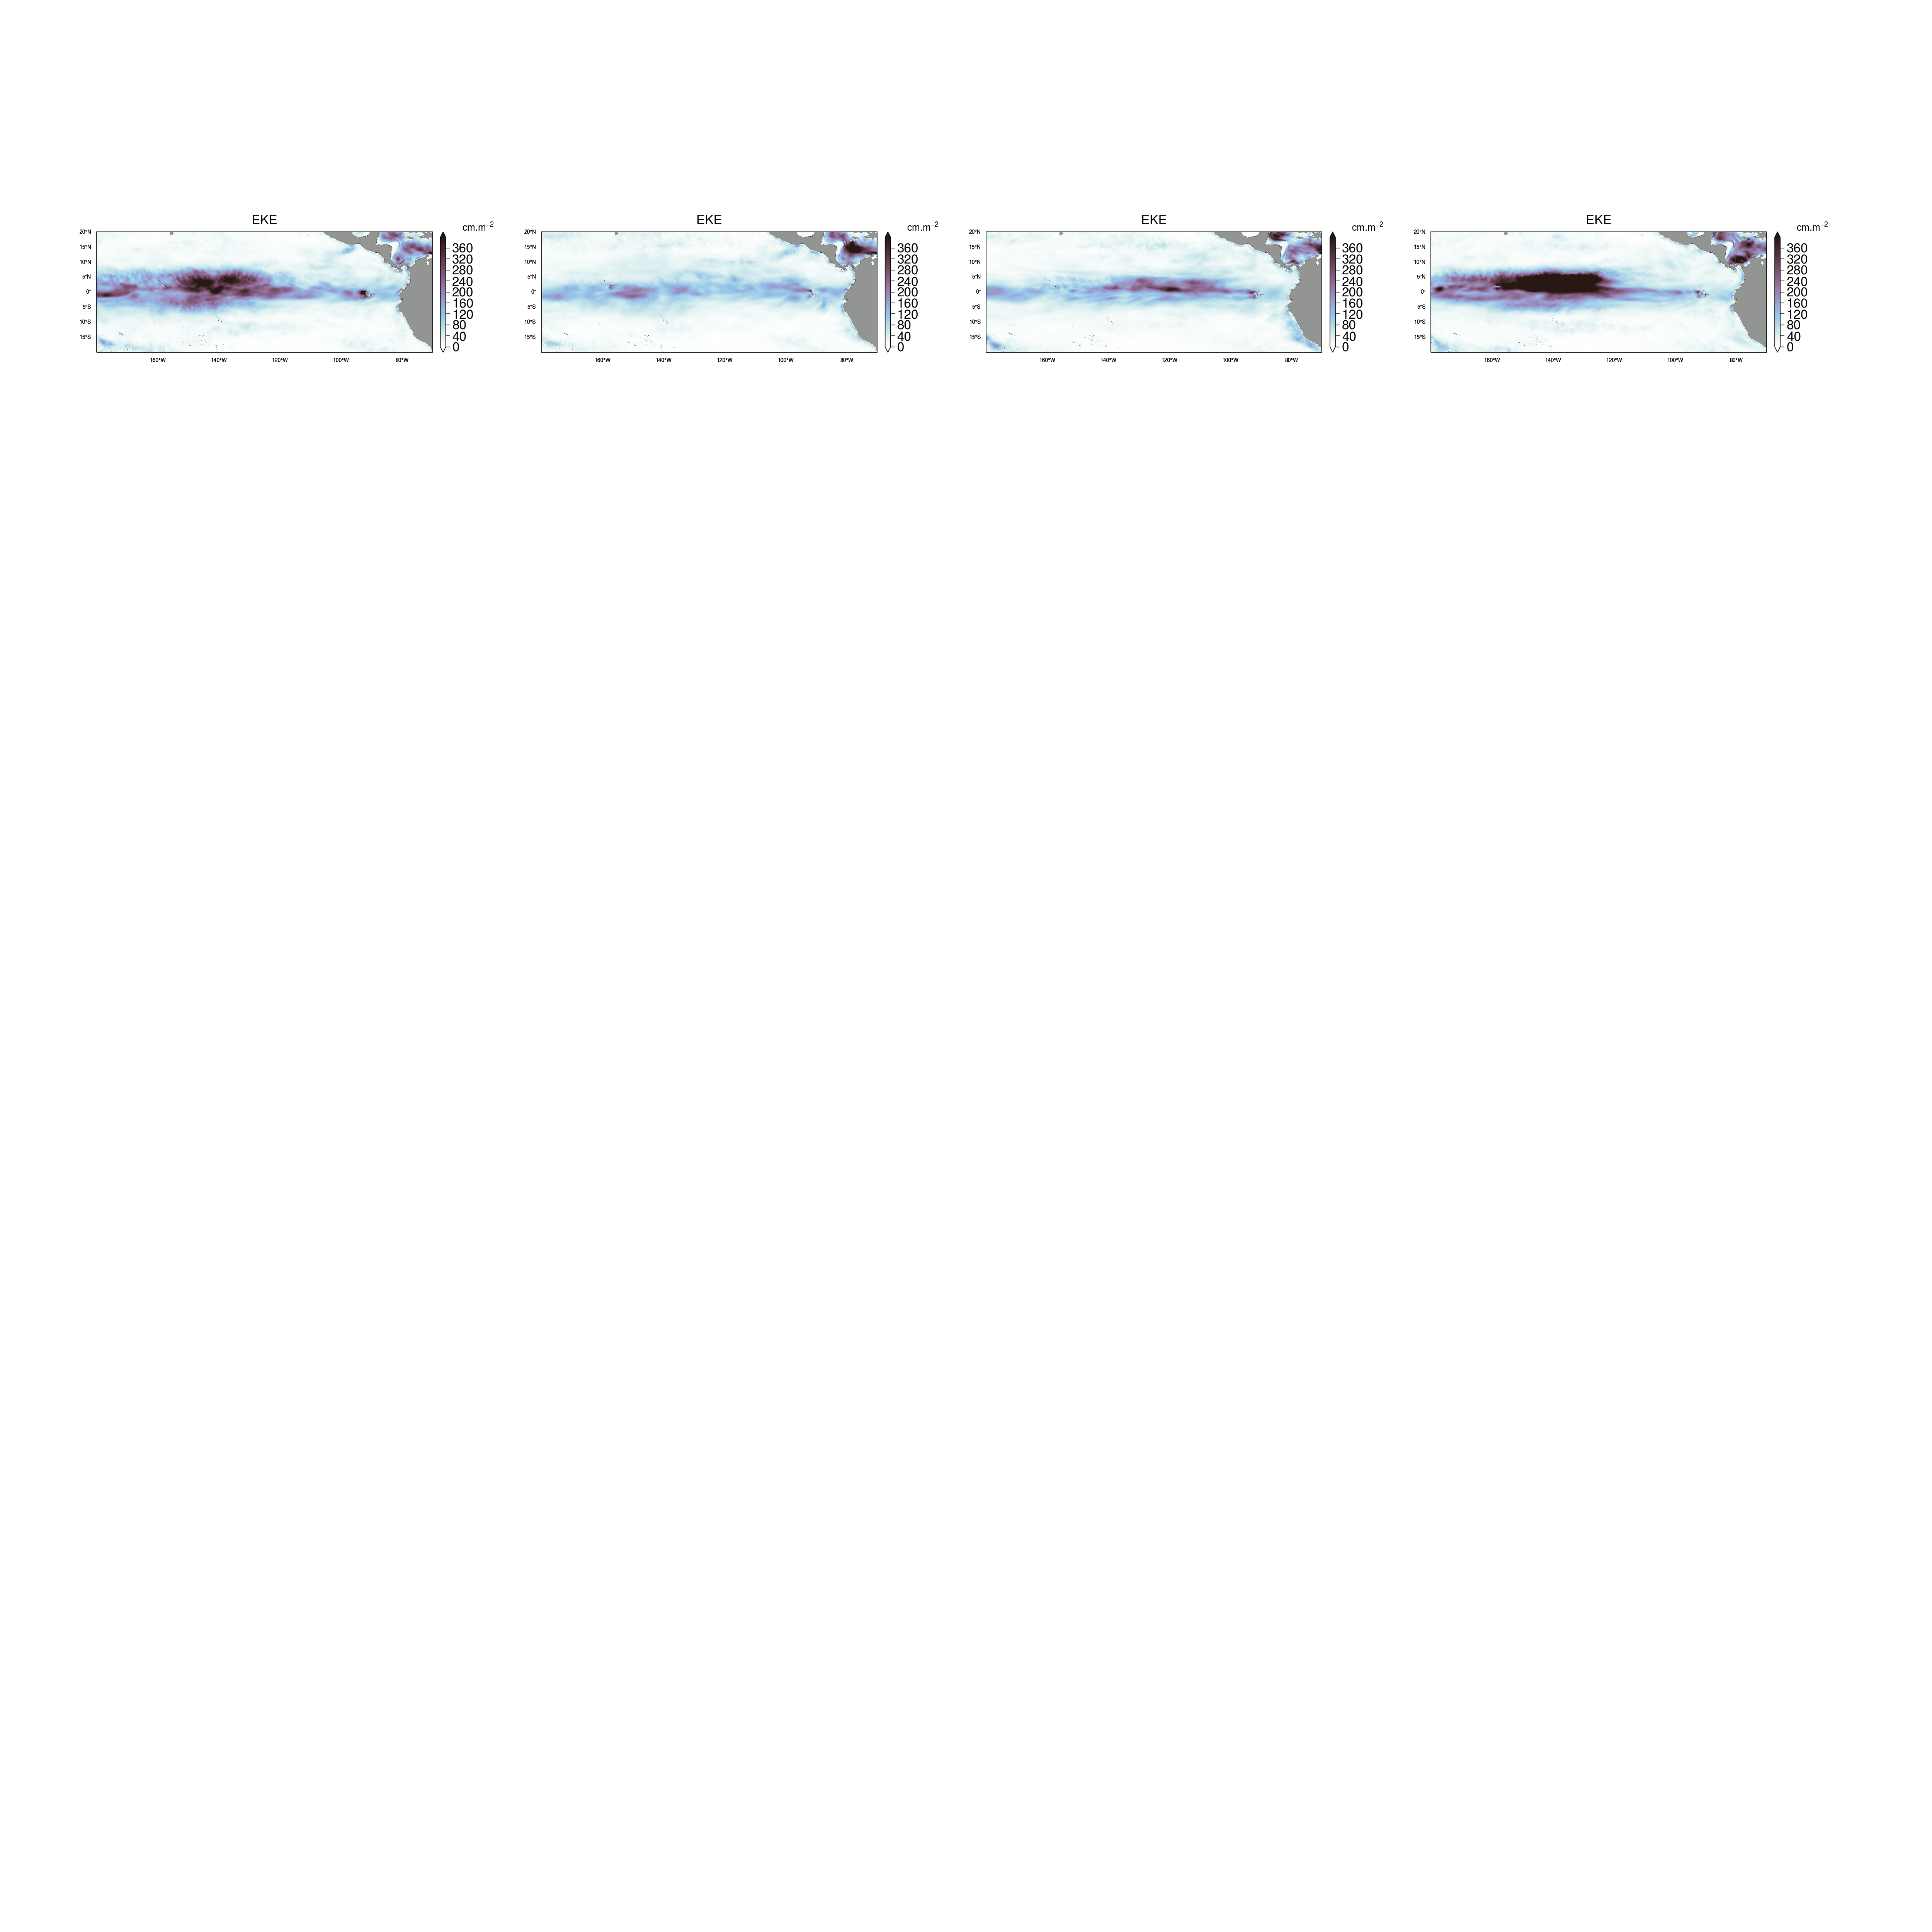

In [168]:
fig = plt.figure(figsize=(25,25),dpi=100)

fs=12; fsx=5; 
SS=-20; NN=20
tops=0. ; bots=500.; 
coords=[[bots,tops],[SS,NN]]

clr_o2='NegPos'
om_clr='blue'
omz_clr='green'
odz_clr='lime'
VAR= [EKEm.__xarray_dataarray_variable__]
cntf= True ; cnt= False 
units=['cm.m$^{-2}$']
title=[r'EKE',  ]
clrs=['glacial']
lw=0.5; alp=1;cb_on=True

lmin = 0; lmax = 400;  lstp = 1
y=dsh.TLAT[:,E]
z= dsh.z_t*1e-2

gs = fig.add_gridspec(nrows=6, ncols=4, bottom=0.35,left=0.05, right=0.95, wspace=0.1, hspace=0.5)
rng=[0,1,2,3,4,5]
r=[0,1,2,3,4,5]
c=[0,1,2,3]
rr=[[0,1,11],
    [2,3,4],
    [5,6,7],
    [8,9,10]]
    

for j in tqdm(np.arange(0,4)):#len(VAR))):
    for i in tqdm(np.arange(0,1)):#len(VAR))):
        ax = fig.add_subplot(gs[r[i], c[j]] ,projection=ccrs.PlateCarree())
        ax = plot_cmap(ax,dsh.TLONG,dsh.TLAT, VAR[i].isel(month=rr[j]).mean('month'),lmin, lmax, lstp,
                       clrs[0],units[0],title[i],coor,fs,fsx, lon_lab,lat_lab)
        gl=ax.gridlines(draw_labels=True)
        gl.xlabel_style = {'size': fsx, 'color': 'black'}; gl.ylabel_style = {'size': fsx, 'color': 'black'}; 
        gl.xlabels_top = False; gl.ylabels_right= False; gl.xlines = False; gl.ylines = False
        gl.xlocator = mticker.FixedLocator(lon_lab); gl.ylocator = mticker.FixedLocator(lat_lab)
        gl.xformatter = LONGITUDE_FORMATTER ; gl.yformatter = LATITUDE_FORMATTER
fig.tight_layout

In [187]:
var= [dsh.TEND_O2.isel(nlon=slice(W,E)).sum('nlon')*nmol_mol/(dsh.VOL.isel(nlon=slice(W,E)).sum('nlon')*cm3_m3),
      dsh.DIV.isel(nlon=slice(W,E)).sum('nlon')*nmol_mol/(dsh.VOL.isel(nlon=slice(W,E)).sum('nlon')*cm3_m3),
      dsh.DIVm.isel(nlon=slice(W,E)).sum('nlon')*nmol_mol/(dsh.VOL.isel(nlon=slice(W,E)).sum('nlon')*cm3_m3),
      dsh.DIVp.isel(nlon=slice(W,E)).sum('nlon')*nmol_mol/(dsh.VOL.isel(nlon=slice(W,E)).sum('nlon')*cm3_m3),
      dsh.VDIF.isel(nlon=slice(W,E)).sum('nlon')*nmol_mol/(dsh.VOL.isel(nlon=slice(W,E)).sum('nlon')*cm3_m3),
      dsh.J_O2.isel(nlon=slice(W,E)).sum('nlon')*nmol_mol/(dsh.VOL.isel(nlon=slice(W,E)).sum('nlon')*cm3_m3),
      EKEm.__xarray_dataarray_variable__.isel(nlon=slice(W,E)).mean('nlon')]

100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


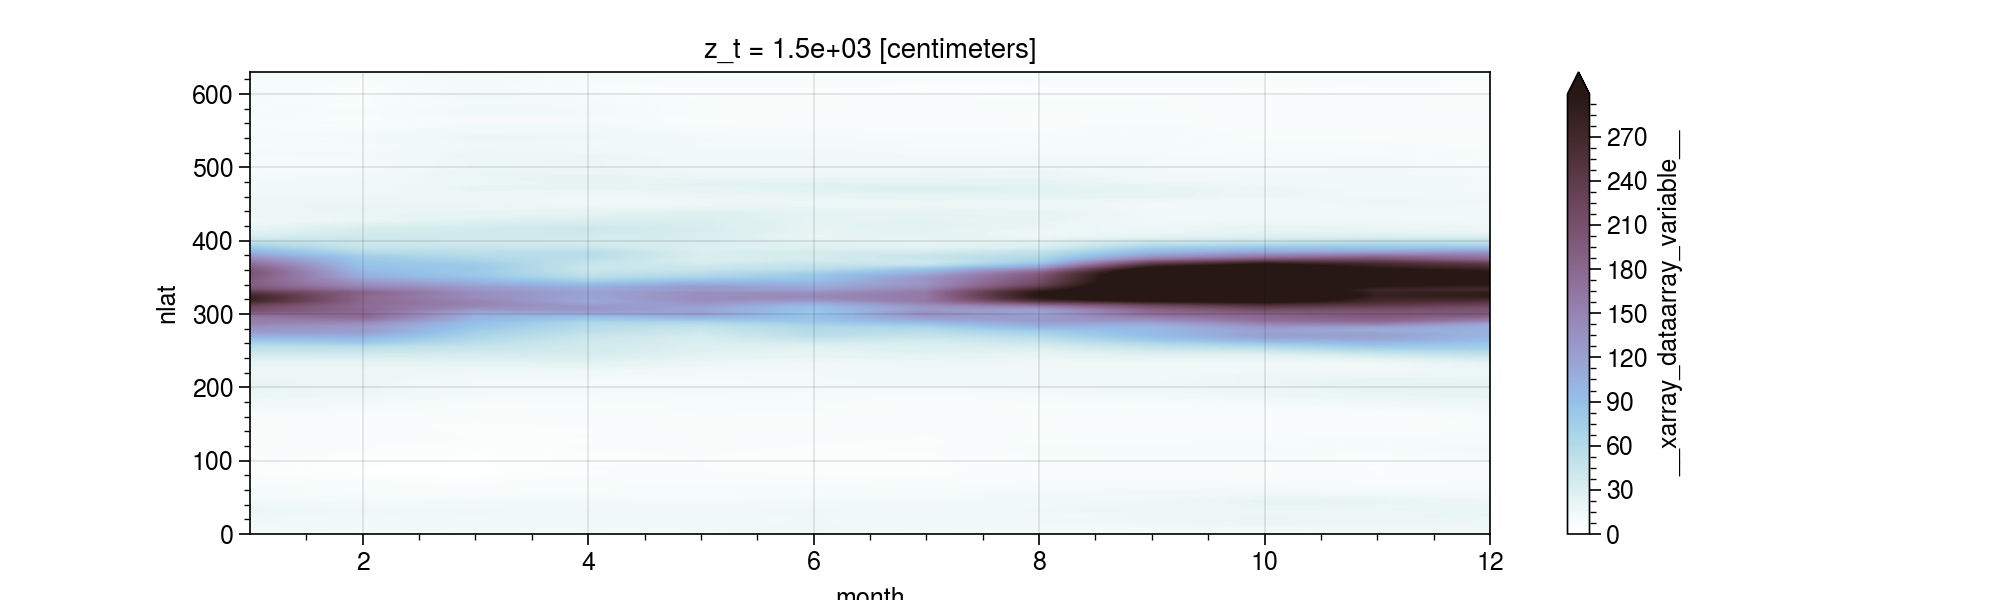

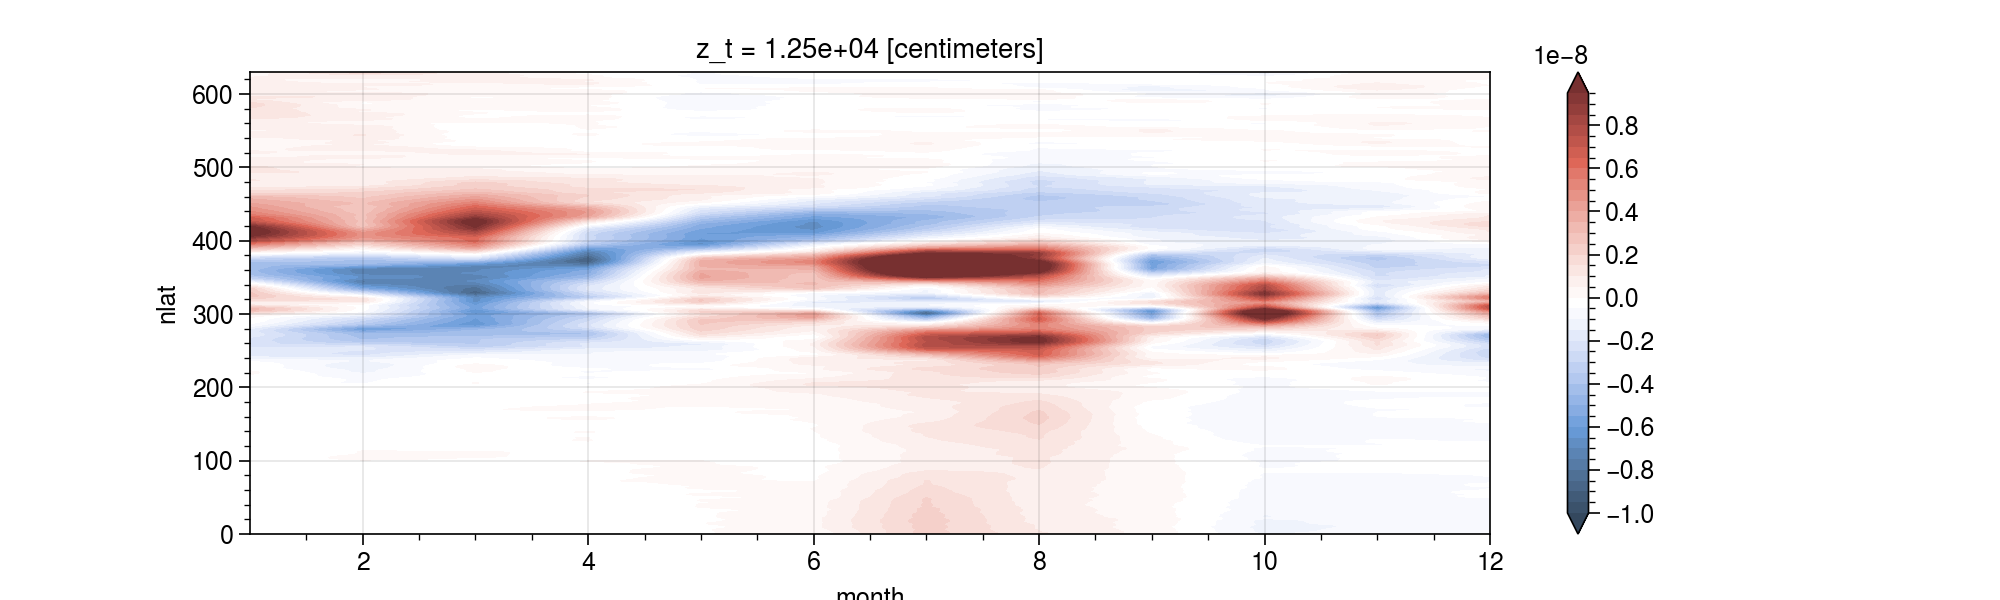

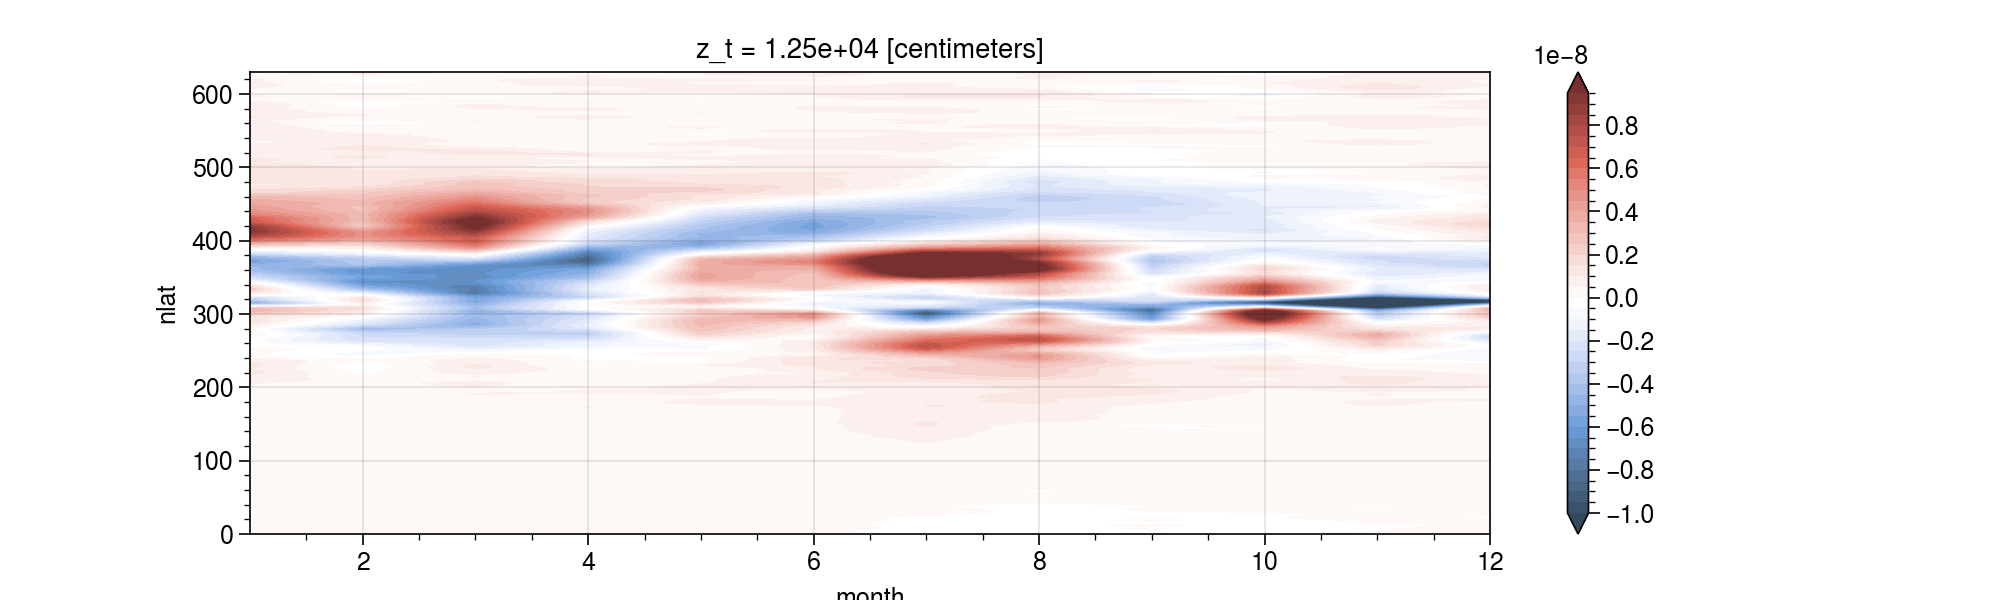

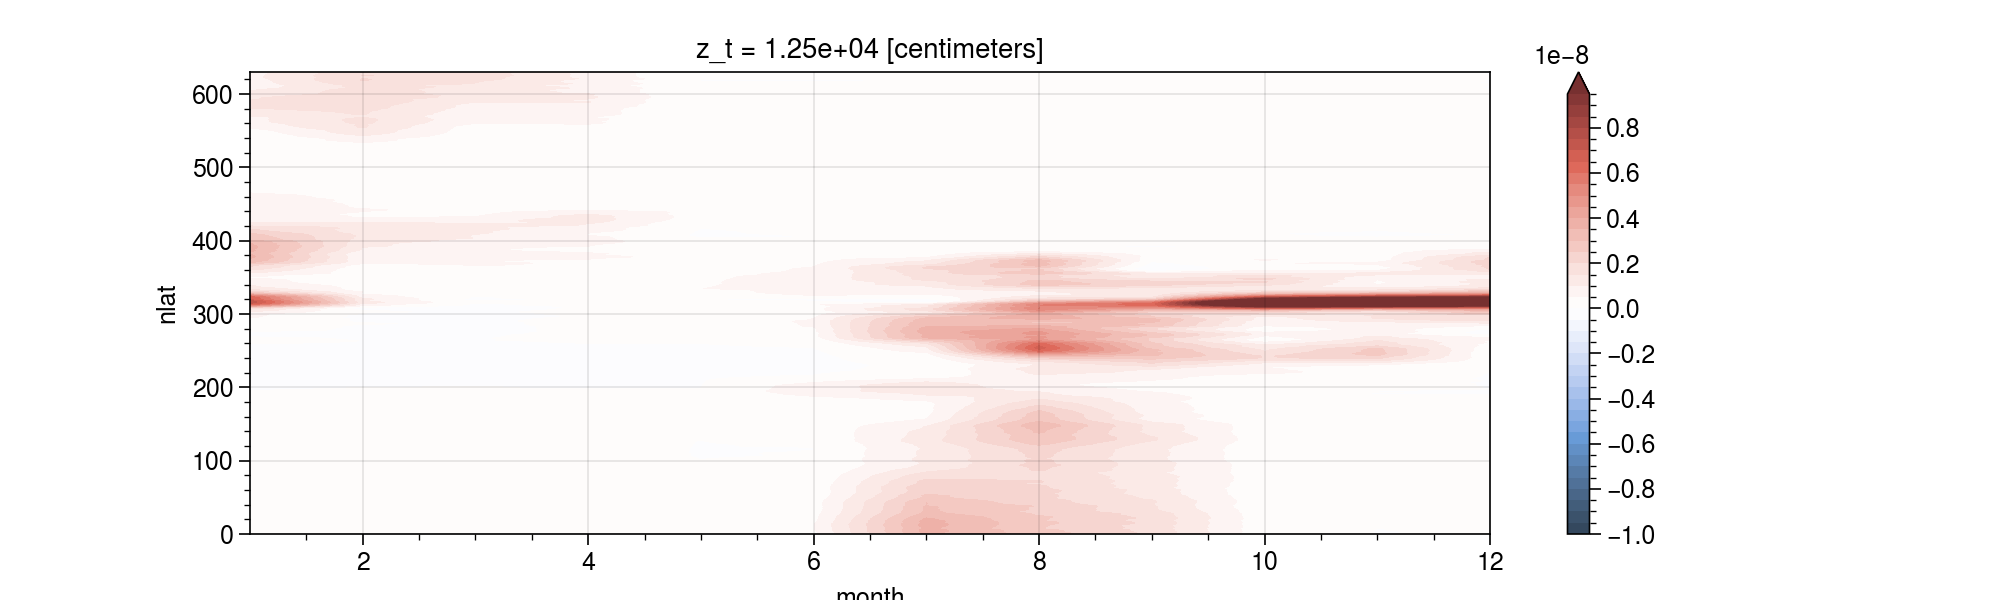

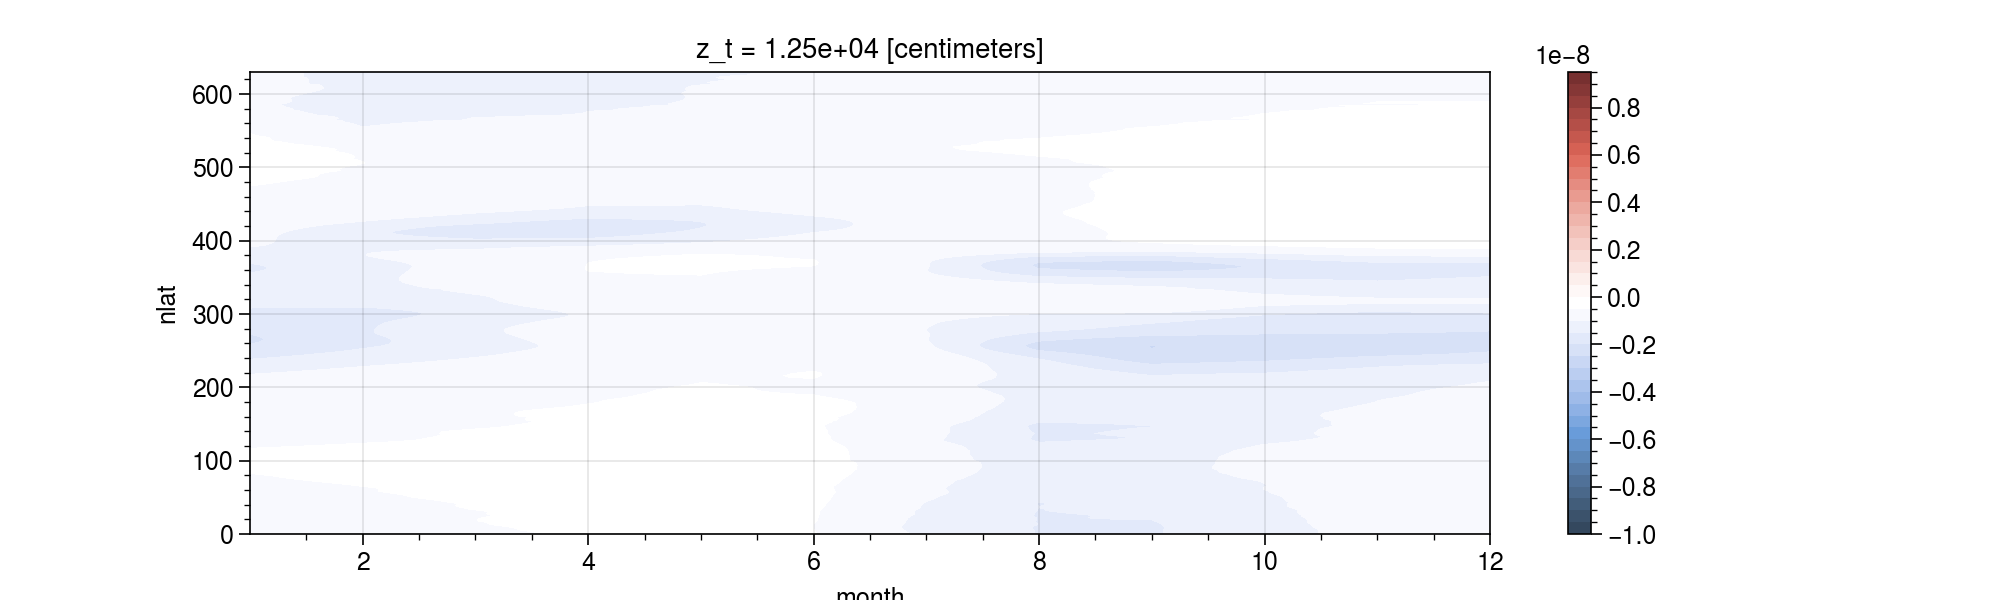

In [195]:
EKEm.__xarray_dataarray_variable__.isel(nlon=slice(W,E)).mean('nlon').plot.contourf(x='month',levels=np.arange(0,300,1),figsize=(10,3),cmap='glacial')

for i in tqdm([0,1,4,5]):
    var[i].isel(z_t=12).plot.contourf(x='month',robust=True,figsize=(10,3),levels=np.arange(-1e-8,1e-8,0.5e-9),cmap='negpos')

100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


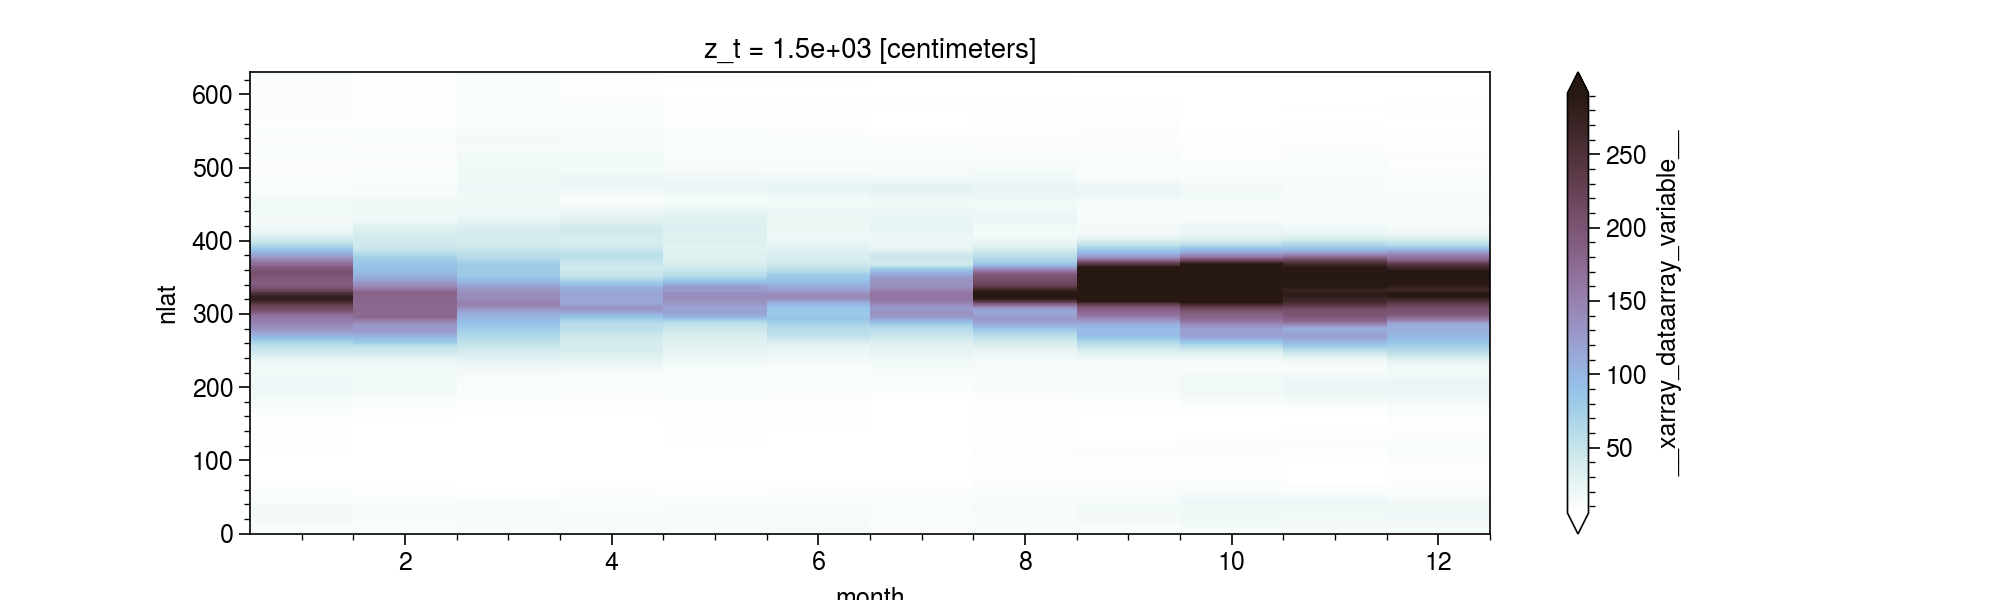

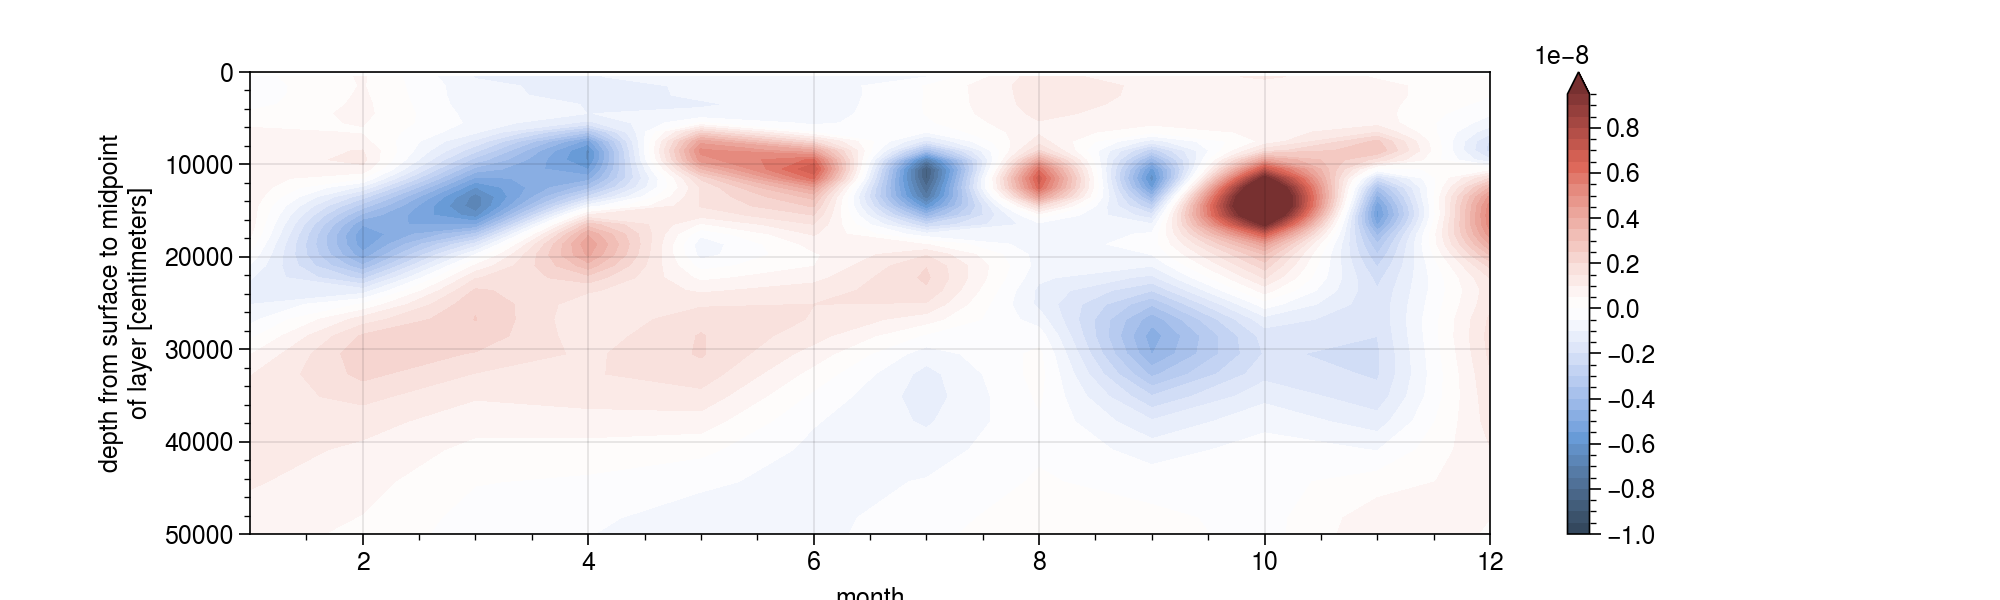

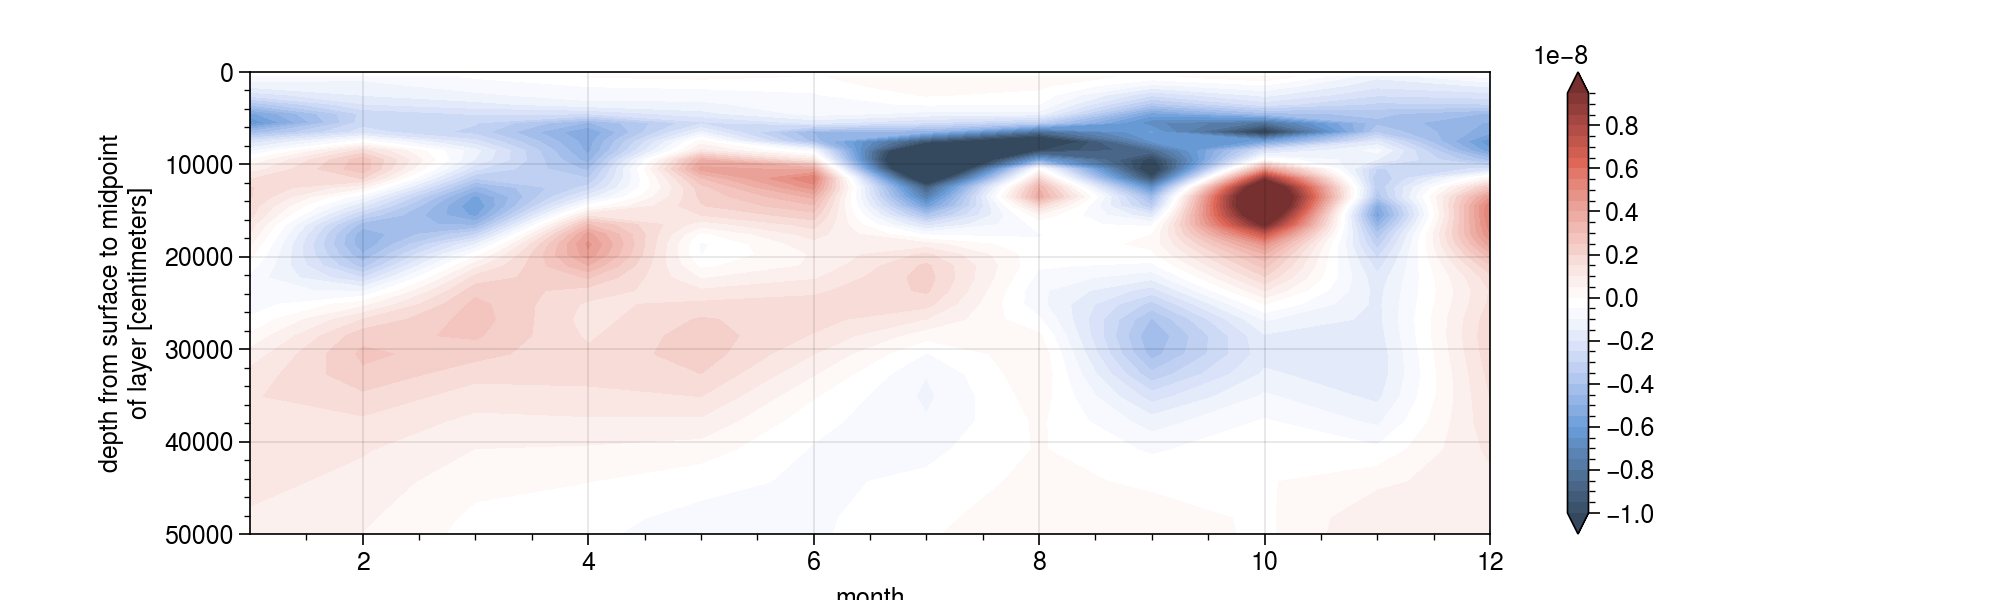

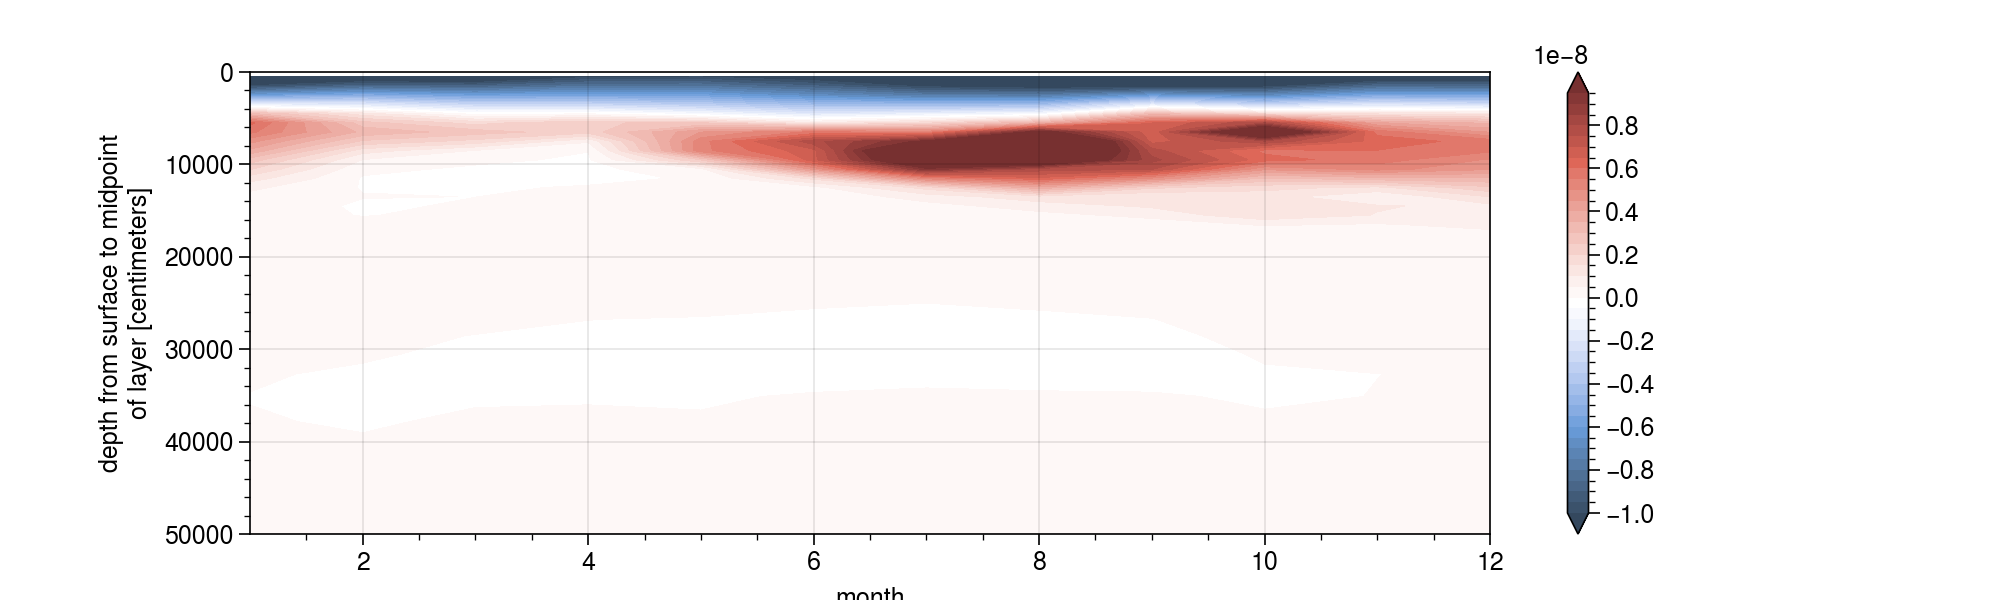

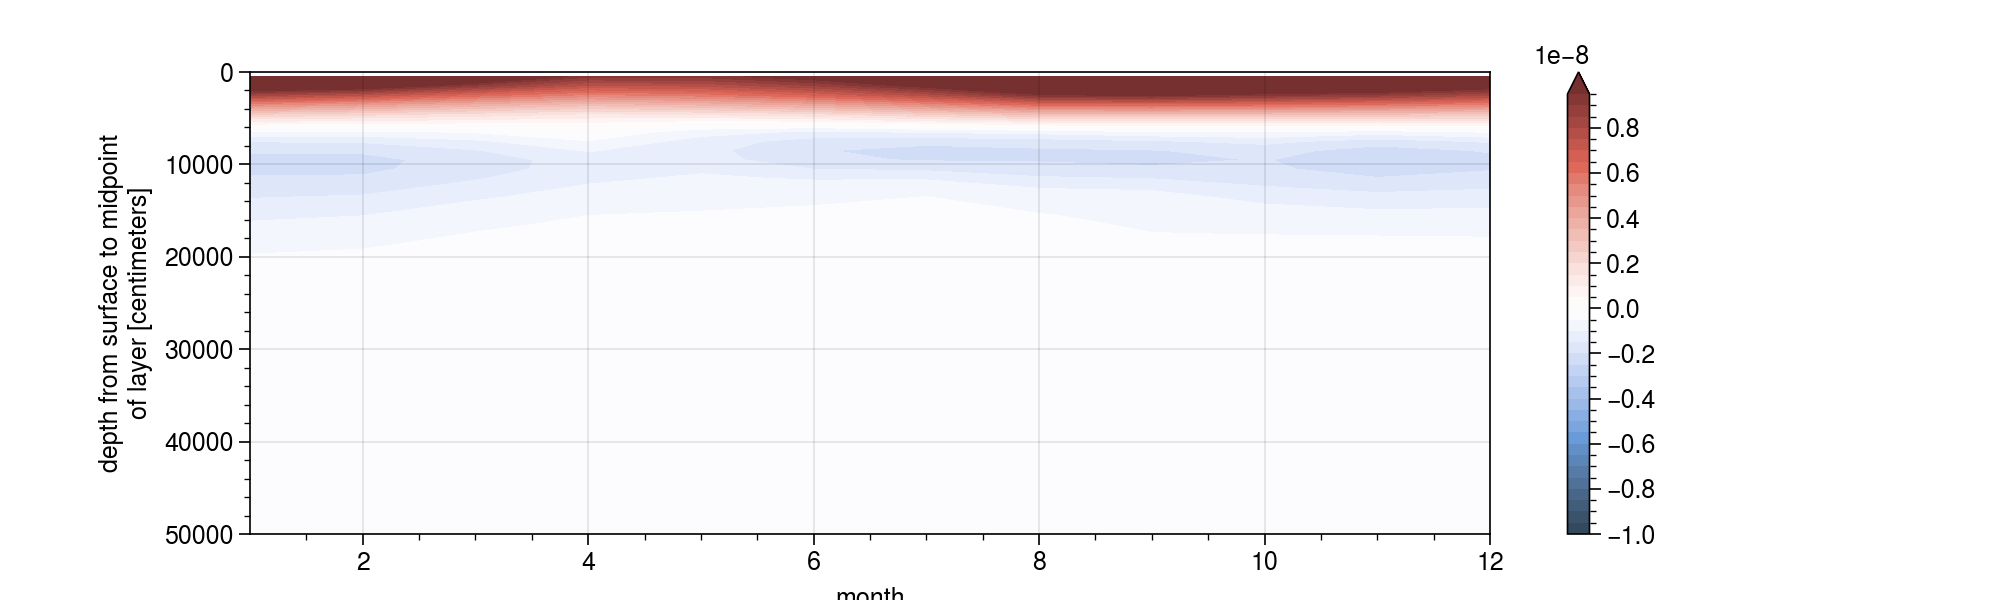

In [197]:
EKEm.__xarray_dataarray_variable__.isel(nlon=slice(W,E)).mean('nlon').plot(x='month',robust=True,figsize=(10,3),cmap='glacial')

for i in tqdm([0,1,4,5]):
    var[i].isel(nlat=300).plot.contourf(x='month',robust=True,figsize=(10,3),levels=np.arange(-1e-8,1e-8,0.5e-9),cmap='negpos')
    plt.ylim(50000,0)